In [37]:
from linares_plot import *
import os
import statsmodels.api as sm
from joblib import Parallel, delayed
import multiprocessing
from scipy.optimize import curve_fit
from sklearn.model_selection import LeaveOneOut


In [ ]:
numcores = multiprocessing.cpu_count() - 1
numcores

In [38]:
def circdist(a1,a2):
    ## Returns the minimal distance in angles between to angles 
    op1=abs(a2-a1)
    angs=[a1,a2]
    op2=min(angs)+(360-max(angs))
    options=[op1,op2]
    return min(options)



def decoding_spikes_angles_err(df, size_test=0.1):
    #### Input : dataframe with three columns: (spikes, behaviour and neuron label)
    ###Take off nans
    df = df.loc[df.iloc[:,0]<9999]
    df.columns=['spikes', 'beh', 'neuron']
    neuron_means=[]
    ### Train and test on the same neuron --> append the error of each neuron
    pop_err=[]
    
    for Neur in df.neuron.unique():
        ### same neuron 5 times --> mean value
        neur_err=[]
        for rep in range(0,5):
            spikes_train, spikes_test, beh_train, beh_test = train_test_split(df.groupby('neuron').get_group(Neur)['spikes'],
                                                                              df.groupby('neuron').get_group(Neur)['beh'],
                                                                              test_size=size_test)  

            ######## Trainning #########
            ## X matrix (intercept and spikes)
            X = np.column_stack([np.ones(np.shape(spikes_train)[0]),spikes_train])
            ## Y (sinus and cos)
            sinus =np.sin([np.radians(np.array(beh_train)[i]) for i in range(0, len(beh_train))])
            cosinus = np.cos([np.radians(np.array(beh_train)[i]) for i in range(0, len(beh_train))])
            Y = np.column_stack([cosinus, sinus])
            ### one OLS for sin and cos: output: beta of intercetp and bea of spikes (two B intercepts and 2 B for spikes )
            Y = Y.astype(float) #to make it work in the cluster
            X = X.astype(float)
            model = sm.OLS(Y, X)
            ##train the model
            fit=model.fit()

            ######### Testing ###########
            X = np.column_stack([np.ones(np.shape(spikes_test)[0]),spikes_test])
            p = fit.predict(X)
            x = p[:,0]
            y = p[:,1]
            #####
            ##### Error --> take the resulting vector in sin/cos space
            ### from sin and cos get the angle (-pi, pi)
            #pred_angle = [ np.degrees(np.arctan2(y[i], x[i]) + np.pi) for i in range(0, len(y))]
            pred_angle = [ np.degrees(np.arctan2(y[i], x[i])) for i in range(0, len(y))]
            for i in range(0, len(pred_angle)):
                if pred_angle[i]<0:
                    pred_angle[i]=360+pred_angle[i]
            ##
            #error=[ circdist(beh_test[i], pred_angle[i]) for i in range(0, len(pred_angle))]
            error=[ circdist(beh_test.values[i], pred_angle[i]) for i in range(0, len(pred_angle))]
            
            #low_value --> predicted positionns close to real
            neur_err.append(np.mean(error))
            ####
        
        #####       
        pop_err.append(np.mean(neur_err))
        ####
    
    return pop_err




In [50]:
path_CTD = 'C:\\Users\\David\\Desktop\\IDIBAPS\\Gottlib_data\\CTD'


In [51]:
pfc_100 = pd.read_excel( os.path.join(path_CTD, 'pfc_100.xlsx'))
pfc_200 = pd.read_excel( os.path.join(path_CTD, 'pfc_200.xlsx'))
pfc_300 = pd.read_excel( os.path.join(path_CTD, 'pfc_300.xlsx'))
pfc_900 = pd.read_excel( os.path.join(path_CTD, 'pfc_900.xlsx'))

In [52]:
lip_100 = pd.read_excel( os.path.join(path_CTD, 'lip_100.xlsx'))
lip_200 = pd.read_excel( os.path.join(path_CTD, 'lip_200.xlsx'))
lip_300 = pd.read_excel( os.path.join(path_CTD, 'lip_300.xlsx'))
lip_900 = pd.read_excel( os.path.join(path_CTD, 'lip_900.xlsx'))

In [ ]:
### Cross temporal decoding

In [162]:
def circdist(a1,a2):
    ## Returns the minimal distance in angles between to angles 
    op1=abs(a2-a1)
    angs=[a1,a2]
    op2=min(angs)+(360-max(angs))
    options=[op1,op2]
    return min(options)



def decoder(df_train, df_test):
    #### Input : dataframe with three columns: (spikes, behaviour and neuron label)
    df_train.columns=['firing', 'beh']
    df_test.columns=['firing', 'beh']
    
    ## Train and test         
    activity_train= df_train.firing.values
    activity_test= df_test.firing.values
    beh_train= df_train.beh.values
    beh_test= df_test.beh.values

    ######## Trainning #########
    ## X matrix (intercept and spikes)
    X = np.column_stack([np.ones(np.shape(activity_train)[0]), activity_train])
    ## Y (sinus and cos)
    sinus =np.sin([np.radians(np.array(beh_train)[i]) for i in range(0, len(beh_train))])
    cosinus = np.cos([np.radians(np.array(beh_train)[i]) for i in range(0, len(beh_train))])
    Y = np.column_stack([cosinus, sinus])
    ### one OLS for sin and cos: output: beta of intercetp and bea of spikes (two B intercepts and 2 B for spikes )
    model = sm.OLS(Y, X)
    ##train the model
    fit=model.fit()

    ######### Testing ###########
    X = np.column_stack([np.ones(np.shape(activity_test)[0]),activity_test])
    p = fit.predict(X)
    x = p[:,0]
    y = p[:,1]
    #####
    ##### Error --> take the resulting vector in sin/cos space
    ### from sin and cos get the angle (-pi, pi)
    #pred_angle = [ np.degrees(np.arctan2(y[i], x[i]) + np.pi) for i in range(0, len(y))]
    pred_angle = [ np.degrees(np.arctan2(y[i], x[i])) for i in range(0, len(y))]
    for i in range(0, len(pred_angle)):
        if pred_angle[i]<0:
            pred_angle[i]=360+pred_angle[i]
    ##
    #
    #print(beh_test)
    error_trial=[ circdist(beh_test[i], pred_angle[i]) for i in range(0, len(pred_angle))]
    mean_error = np.round(np.mean(error_trial),2)

    return mean_error


def heatmap(data, title, dist_time='None', fs1=20, fs2=12):
    ax = sns.heatmap(data,vmin=50, vmax=90, cmap= 'viridis_r',
                    cbar_kws={"shrink": .82, 'ticks' : [50, 70, 90], 'label': 'decoding error ($^\circ$)'}) ##sns.cm.rocket_r
    ax.invert_yaxis()
    ax.figure.axes[-1].yaxis.label.set_size(fs1)
    ax.figure.axes[-1].tick_params(labelsize=fs2)
    plt.gca().set_title(title, fontsize=fs1)
    plt.gca().set_xticks([0,5,10,15,20])
    plt.gca().set_xticklabels([-500,0,500,1000,1500])
    plt.gca().set_ylim(0,24)
    plt.gca().set_yticks([0,5,10,15,20])
    plt.gca().set_yticklabels([-500,0,500,1000,1500])
    plt.xticks(fontsize=fs2, rotation=0)
    plt.yticks(fontsize=fs2)
    plt.gca().set_ylabel('training time (ms)', fontsize=fs1, labelpad=12)
    plt.gca().set_xlabel('testing time (ms)', fontsize=fs1, labelpad=12)
    ##### Target presented at 500ms
    ##### Stimulus duration: 100ms
    ##### Distractor presented with different SOA
    plt.plot([500/100, 500/100], [23,23], markersize=10, color='y', marker='v')
    if dist_time != 'None':
        plt.plot([(600+dist_time)/100, (600+dist_time)/100], [23,23], markersize=10, color='r', marker='v')
                
    
    plt.show(block=False)

    

### Example 1 neuron

In [175]:
neuron_ = pfc_100.neuron.unique()[0]
print(neuron_)
## get the neuron
dfN = pfc_100.loc[pfc_100['neuron']==neuron_]
## column of times centered to stim onset
dfN['times_centered'] = dfN['times'] - dfN['fixationtime']

#cross-decoding for 1 neuron
### empty matrix to append the cross temporal decoding
all_times = np.arange(-500,2100, 100)
train_test = np.empty( (len(all_times), len(all_times) ) )
train_test[:] = np.nan

### times I am interested in (no need to get more times)
dfN = dfN.loc[(dfN['times_centered']>=-500) & (dfN['times_centered']<=2000) ]
list_times = dfn.times_centered.unique()
list_times_sorted =np.sort(list_times)
list_times_sorted

for training_time in list_times_sorted:
    #print(training_time)
    dfn_train = dfN.loc[(dfN['times_centered']==training_time), ['firing', 'target_angle']]
    dfn_train = dfn_train.loc[dfn_train.iloc[:,0]<9999] ###Take off nans
    paralel_train = [dfn_train for i in range(len(list_times_sorted))]
    
    paralel_test = []
    for times_testing in list_times_sorted:
        dfn_test =dfN.loc[(dfN['times_centered']==times_testing), ['firing', 'target_angle']]
        dfn_test = dfn_test.loc[dfn_test.iloc[:,0]<9999] ###Take off nans
        paralel_test.append(dfn_test)

    cross_temp = Parallel(n_jobs = numcores)(delayed(decoder)(training, testing)  for training, testing in zip(paralel_train, paralel_test) )   #### reconstruction standard (paralel)

    idx_append_row = np.where(training_time == all_times )[0][0]
    idx_append_col1 = np.where(list_times_sorted[0] == all_times)[0][0]
    idx_append_col2 = np.where(list_times_sorted[-1] == all_times)[0][0]
    train_test[idx_append_row, idx_append_col1:idx_append_col2+1] = cross_temp

1367701


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


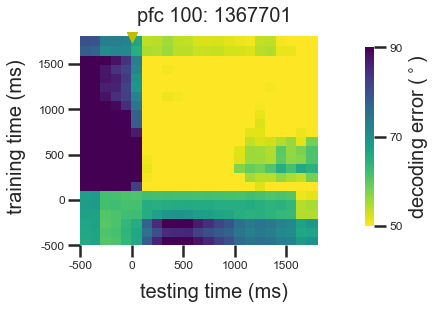

In [176]:
heatmap(train_test, 'pfc 100: ' + str(neuron_))

### All neurons in one condition

## pfc, tdoa=100

In [169]:
len(pfc_100.neuron.unique()) ##number of neurons

63

In [174]:
heatmaps_pfc_100=[]

for n_neuron,neuron_ in enumerate(pfc_100.neuron.unique()):
    print(n_neuron, neuron_)
    ## get the neuron
    dfN = pfc_100.loc[pfc_100['neuron']==neuron_]
    ## column of times centered to stim onset
    dfN['times_centered'] = dfN['times'] - dfN['fixationtime']

    #cross-decoding for 1 neuron
    ### empty matrix to append the cross temporal decoding
    all_times = np.arange(-500,2100, 100)
    train_test = np.empty( (len(all_times), len(all_times) ) )
    train_test[:] = np.nan

    ### times I am interested in (no need to get more times)
    dfN = dfN.loc[(dfN['times_centered']>=-500) & (dfN['times_centered']<=2000) ]
    list_times = dfn.times_centered.unique()
    list_times_sorted =np.sort(list_times)
    list_times_sorted

    for training_time in list_times_sorted:
        #print(training_time)
        dfn_train = dfN.loc[(dfN['times_centered']==training_time), ['firing', 'target_angle']]         
        dfn_train = dfn_train.loc[dfn_train.iloc[:,0]<9999] ###Take off nans
        paralel_train = [dfn_train for i in range(len(list_times_sorted))]

        paralel_test = []
        for times_testing in list_times_sorted:
            dfn_test =dfN.loc[(dfN['times_centered']==times_testing), ['firing', 'target_angle']]
            dfn_test = dfn_test.loc[dfn_test.iloc[:,0]<9999] ###Take off nans
            paralel_test.append(dfn_test)

        cross_temp = Parallel(n_jobs = numcores)(delayed(decoder)(training, testing)  for training, testing in zip(paralel_train, paralel_test) )   #### reconstruction standard (paralel)

        idx_append_row = np.where(training_time == all_times )[0][0]
        idx_append_col1 = np.where(list_times_sorted[0] == all_times)[0][0]
        idx_append_col2 = np.where(list_times_sorted[-1] == all_times)[0][0]
        train_test[idx_append_row, idx_append_col1:idx_append_col2+1] = cross_temp
    ##
    heatmaps_pfc_100.append(train_test)

0 1367701


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


1 1367802
2 1367903
3 1369702
4 1369901
5 1370002
6 1370202
7 1371202
8 1371901
9 1372003
10 1372301
11 1372402
12 189168701
13 189169502
14 189171003
15 189171602
16 189172801
17 189173101
18 189173801
19 189174201
20 189175201
21 189175801
22 189176101
23 189176501
24 189176901
25 189177402
26 189177701
27 1891783
28 189179001
29 189179002
30 1891793
31 189179702
32 189180001
33 189181001
34 189181502
35 1891819
36 189182202
37 189182501
38 189182901
39 189183201
40 189183402
41 1891841
42 189184601
43 1891857
44 189186201
45 189187301
46 189188901
47 189189601
48 189191601
49 189191602
50 1891918
51 189192001
52 189192201
53 189192401
54 1891935
55 189194301
56 189195301
57 189196301
58 189196401
59 189209101
60 189209503
61 189210001
62 189210901


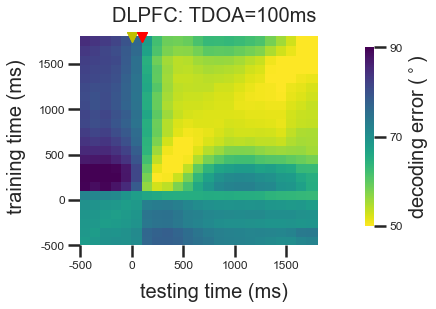

In [183]:
H = [pd.DataFrame(heatmaps_pfc_100[x]) for x in range(len(heatmaps_pfc_100))]
H_mean = pd.concat(H).groupby(level=0).mean()
heatmap(H_mean, 'DLPFC: TDOA=' +str(100)+'ms', dist_time=0)

## pfc, tdoa=200

In [184]:
heatmaps_pfc_200=[]

for n_neuron,neuron_ in enumerate(pfc_200.neuron.unique()):
    print(n_neuron, neuron_)
    ## get the neuron
    dfN = pfc_200.loc[pfc_200['neuron']==neuron_]
    ## column of times centered to stim onset
    dfN['times_centered'] = dfN['times'] - dfN['fixationtime']

    #cross-decoding for 1 neuron
    ### empty matrix to append the cross temporal decoding
    all_times = np.arange(-500,2100, 100)
    train_test = np.empty( (len(all_times), len(all_times) ) )
    train_test[:] = np.nan

    ### times I am interested in (no need to get more times)
    dfN = dfN.loc[(dfN['times_centered']>=-500) & (dfN['times_centered']<=2000) ]
    list_times = dfn.times_centered.unique()
    list_times_sorted =np.sort(list_times)
    list_times_sorted

    for training_time in list_times_sorted:
        #print(training_time)
        dfn_train = dfN.loc[(dfN['times_centered']==training_time), ['firing', 'target_angle']]         
        dfn_train = dfn_train.loc[dfn_train.iloc[:,0]<9999] ###Take off nans
        paralel_train = [dfn_train for i in range(len(list_times_sorted))]

        paralel_test = []
        for times_testing in list_times_sorted:
            dfn_test =dfN.loc[(dfN['times_centered']==times_testing), ['firing', 'target_angle']]
            dfn_test = dfn_test.loc[dfn_test.iloc[:,0]<9999] ###Take off nans
            paralel_test.append(dfn_test)

        cross_temp = Parallel(n_jobs = numcores)(delayed(decoder)(training, testing)  for training, testing in zip(paralel_train, paralel_test) )   #### reconstruction standard (paralel)

        idx_append_row = np.where(training_time == all_times )[0][0]
        idx_append_col1 = np.where(list_times_sorted[0] == all_times)[0][0]
        idx_append_col2 = np.where(list_times_sorted[-1] == all_times)[0][0]
        train_test[idx_append_row, idx_append_col1:idx_append_col2+1] = cross_temp
    ##
    heatmaps_pfc_200.append(train_test)

0 1367701


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


1 1367802
2 1367903
3 1369702
4 1369901
5 1370002
6 1370202
7 1371202
8 1371901
9 1372003
10 1372301
11 1372402
12 189168701
13 189169502
14 189171003
15 189171602
16 189172801
17 189173101
18 189173801
19 189174201
20 189175201
21 189175801
22 189176101
23 189176501
24 189176901
25 189177402
26 189177701
27 1891783
28 189179001
29 189179002
30 1891793
31 189179702
32 189180001
33 189181001
34 189181502
35 1891819
36 189182202
37 189182501
38 189182901
39 189183201
40 189183402
41 1891841
42 189184601
43 1891857
44 189186201
45 189187301
46 189188901
47 189189601
48 189191601
49 189191602
50 1891918
51 189192001
52 189192201
53 189192401
54 1891935
55 189194301
56 189195301
57 189196301
58 189196401
59 189209101
60 189209503
61 189210001
62 189210901


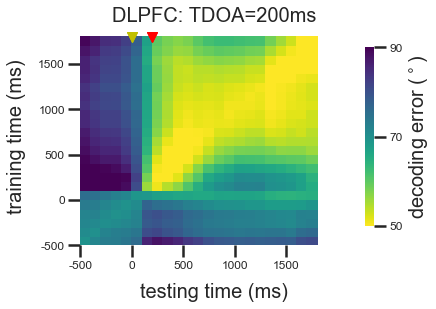

In [185]:
H = [pd.DataFrame(heatmaps_pfc_200[x]) for x in range(len(heatmaps_pfc_200))]
H_mean = pd.concat(H).groupby(level=0).mean()
heatmap(H_mean, 'DLPFC: TDOA=' +str(200)+'ms', dist_time=100)

## pfc, tdoa=300

In [186]:
heatmaps_pfc_300=[]

for n_neuron,neuron_ in enumerate(pfc_300.neuron.unique()):
    print(n_neuron, neuron_)
    ## get the neuron
    dfN = pfc_300.loc[pfc_300['neuron']==neuron_]
    ## column of times centered to stim onset
    dfN['times_centered'] = dfN['times'] - dfN['fixationtime']

    #cross-decoding for 1 neuron
    ### empty matrix to append the cross temporal decoding
    all_times = np.arange(-500,2100, 100)
    train_test = np.empty( (len(all_times), len(all_times) ) )
    train_test[:] = np.nan

    ### times I am interested in (no need to get more times)
    dfN = dfN.loc[(dfN['times_centered']>=-500) & (dfN['times_centered']<=2000) ]
    list_times = dfn.times_centered.unique()
    list_times_sorted =np.sort(list_times)
    list_times_sorted

    for training_time in list_times_sorted:
        #print(training_time)
        dfn_train = dfN.loc[(dfN['times_centered']==training_time), ['firing', 'target_angle']]         
        dfn_train = dfn_train.loc[dfn_train.iloc[:,0]<9999] ###Take off nans
        paralel_train = [dfn_train for i in range(len(list_times_sorted))]

        paralel_test = []
        for times_testing in list_times_sorted:
            dfn_test =dfN.loc[(dfN['times_centered']==times_testing), ['firing', 'target_angle']]
            dfn_test = dfn_test.loc[dfn_test.iloc[:,0]<9999] ###Take off nans
            paralel_test.append(dfn_test)

        cross_temp = Parallel(n_jobs = numcores)(delayed(decoder)(training, testing)  for training, testing in zip(paralel_train, paralel_test) )   #### reconstruction standard (paralel)

        idx_append_row = np.where(training_time == all_times )[0][0]
        idx_append_col1 = np.where(list_times_sorted[0] == all_times)[0][0]
        idx_append_col2 = np.where(list_times_sorted[-1] == all_times)[0][0]
        train_test[idx_append_row, idx_append_col1:idx_append_col2+1] = cross_temp
    ##
    heatmaps_pfc_300.append(train_test)

0 1367701


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


1 1367802
2 1367903
3 1369702
4 1369901
5 1370002
6 1370202
7 1371202
8 1371901
9 1372003
10 1372301
11 1372402
12 189168701
13 189169502
14 189171003
15 189171602
16 189172801
17 189173101
18 189173801
19 189174201
20 189175201
21 189175801
22 189176101
23 189176501
24 189176901
25 189177402
26 189177701
27 1891783
28 189179001
29 189179002
30 1891793
31 189179702
32 189180001
33 189181001
34 189181502
35 1891819
36 189182202
37 189182501
38 189182901
39 189183201
40 189183402
41 1891841
42 189184601
43 1891857
44 189186201
45 189187301
46 189188901
47 189189601
48 189191601
49 189191602
50 1891918
51 189192001
52 189192201
53 189192401
54 1891935
55 189194301
56 189195301
57 189196301
58 189196401
59 189209101
60 189209503
61 189210001
62 189210901


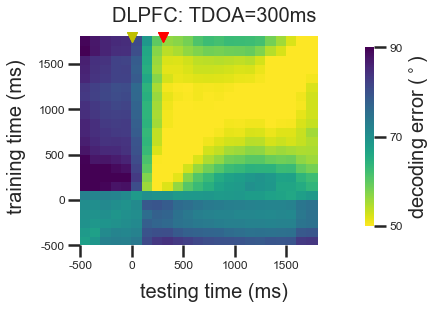

In [187]:
H = [pd.DataFrame(heatmaps_pfc_300[x]) for x in range(len(heatmaps_pfc_300))]
H_mean = pd.concat(H).groupby(level=0).mean()
heatmap(H_mean, 'DLPFC: TDOA=' +str(300)+'ms', dist_time=200)

## pfc, tdoa=900

In [188]:
heatmaps_pfc_900=[]

for n_neuron,neuron_ in enumerate(pfc_900.neuron.unique()):
    print(n_neuron, neuron_)
    ## get the neuron
    dfN = pfc_900.loc[pfc_900['neuron']==neuron_]
    ## column of times centered to stim onset
    dfN['times_centered'] = dfN['times'] - dfN['fixationtime']

    #cross-decoding for 1 neuron
    ### empty matrix to append the cross temporal decoding
    all_times = np.arange(-500,2100, 100)
    train_test = np.empty( (len(all_times), len(all_times) ) )
    train_test[:] = np.nan

    ### times I am interested in (no need to get more times)
    dfN = dfN.loc[(dfN['times_centered']>=-500) & (dfN['times_centered']<=2000) ]
    list_times = dfn.times_centered.unique()
    list_times_sorted =np.sort(list_times)
    list_times_sorted

    for training_time in list_times_sorted:
        #print(training_time)
        dfn_train = dfN.loc[(dfN['times_centered']==training_time), ['firing', 'target_angle']]         
        dfn_train = dfn_train.loc[dfn_train.iloc[:,0]<9999] ###Take off nans
        paralel_train = [dfn_train for i in range(len(list_times_sorted))]

        paralel_test = []
        for times_testing in list_times_sorted:
            dfn_test =dfN.loc[(dfN['times_centered']==times_testing), ['firing', 'target_angle']]
            dfn_test = dfn_test.loc[dfn_test.iloc[:,0]<9999] ###Take off nans
            paralel_test.append(dfn_test)

        cross_temp = Parallel(n_jobs = numcores)(delayed(decoder)(training, testing)  for training, testing in zip(paralel_train, paralel_test) )   #### reconstruction standard (paralel)

        idx_append_row = np.where(training_time == all_times )[0][0]
        idx_append_col1 = np.where(list_times_sorted[0] == all_times)[0][0]
        idx_append_col2 = np.where(list_times_sorted[-1] == all_times)[0][0]
        train_test[idx_append_row, idx_append_col1:idx_append_col2+1] = cross_temp
    ##
    heatmaps_pfc_900.append(train_test)

0 1367701


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


1 1367802
2 1367903
3 1369702
4 1369901
5 1370002
6 1370202
7 1371202
8 1371901
9 1372003
10 1372301
11 1372402
12 189168701
13 189169502
14 189171003
15 189171602
16 189172801
17 189173101
18 189173801
19 189174201
20 189175201
21 189175801
22 189176101
23 189176501
24 189176901
25 189177402
26 189177701
27 1891783
28 189179001
29 189179002
30 1891793
31 189179702
32 189180001
33 189181001
34 189181502
35 1891819
36 189182202
37 189182501
38 189182901
39 189183201
40 189183402
41 1891841
42 189184601
43 1891857
44 189186201
45 189187301
46 189188901
47 189189601
48 189191601
49 189191602
50 1891918
51 189192001
52 189192201
53 189192401
54 1891935
55 189194301
56 189195301
57 189196301
58 189196401
59 189209101
60 189209503
61 189210001
62 189210901


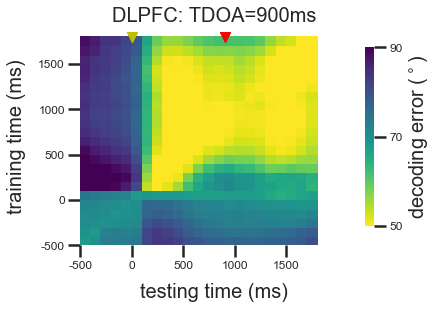

In [189]:
H = [pd.DataFrame(heatmaps_pfc_900[x]) for x in range(len(heatmaps_pfc_900))]
H_mean = pd.concat(H).groupby(level=0).mean()
heatmap(H_mean, 'DLPFC: TDOA=' +str(900)+'ms', dist_time=800)

## LIP, tdoa=100

In [190]:
len(lip_100.neuron.unique()) ##number of neurons

44

In [192]:
heatmaps_lip_100=[]

for n_neuron,neuron_ in enumerate(lip_100.neuron.unique()):
    print(n_neuron, neuron_)
    ## get the neuron
    dfN = lip_100.loc[lip_100['neuron']==neuron_]
    ## column of times centered to stim onset
    dfN['times_centered'] = dfN['times'] - dfN['fixationtime']

    #cross-decoding for 1 neuron
    ### empty matrix to append the cross temporal decoding
    all_times = np.arange(-500,2100, 100)
    train_test = np.empty( (len(all_times), len(all_times) ) )
    train_test[:] = np.nan

    ### times I am interested in (no need to get more times)
    dfN = dfN.loc[(dfN['times_centered']>=-500) & (dfN['times_centered']<=2000) ]
    list_times = dfn.times_centered.unique()
    list_times_sorted =np.sort(list_times)
    list_times_sorted

    for training_time in list_times_sorted:
        #print(training_time)
        dfn_train = dfN.loc[(dfN['times_centered']==training_time), ['firing', 'target_angle']]         
        dfn_train = dfn_train.loc[dfn_train.iloc[:,0]<9999] ###Take off nans
        paralel_train = [dfn_train for i in range(len(list_times_sorted))]

        paralel_test = []
        for times_testing in list_times_sorted:
            dfn_test =dfN.loc[(dfN['times_centered']==times_testing), ['firing', 'target_angle']]
            dfn_test = dfn_test.loc[dfn_test.iloc[:,0]<9999] ###Take off nans
            paralel_test.append(dfn_test)

        cross_temp = Parallel(n_jobs = numcores)(delayed(decoder)(training, testing)  for training, testing in zip(paralel_train, paralel_test) )   #### reconstruction standard (paralel)

        idx_append_row = np.where(training_time == all_times )[0][0]
        idx_append_col1 = np.where(list_times_sorted[0] == all_times)[0][0]
        idx_append_col2 = np.where(list_times_sorted[-1] == all_times)[0][0]
        train_test[idx_append_row, idx_append_col1:idx_append_col2+1] = cross_temp
    ##
    heatmaps_lip_100.append(train_test)

0 1364705


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


1 1365201
2 1365301
3 1365501
4 1365701
5 1365802
6 1365902
7 1366002
8 1366101
9 189139306
10 1891406
11 1891407
12 189141804
13 1891421
14 1891436
15 189144701
16 189144904
17 189147105
18 189150602
19 189151102
20 189152601
21 189154404
22 189154602
23 189155501
24 189156205
25 189157901
26 189158601
27 1891598
28 189160302
29 189160702
30 189161604
31 1891626
32 189163101
33 189163701
34 189164103
35 189164404
36 189164801
37 189164803
38 189165003
39 1891653
40 1892063
41 189207101
42 189207501
43 189208001


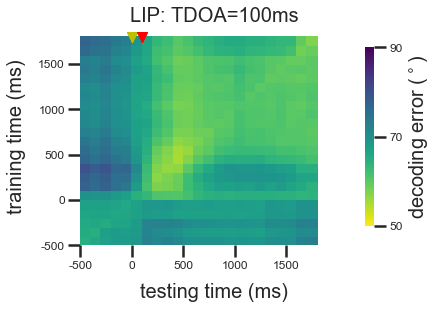

In [193]:
H = [pd.DataFrame(heatmaps_lip_100[x]) for x in range(len(heatmaps_lip_100))]
H_mean = pd.concat(H).groupby(level=0).mean()
heatmap(H_mean, 'LIP: TDOA=' +str(100)+'ms', dist_time=0)

## LIP, tdoa=200

In [191]:
heatmaps_lip_200=[]

for n_neuron,neuron_ in enumerate(lip_200.neuron.unique()):
    print(n_neuron, neuron_)
    ## get the neuron
    dfN = lip_200.loc[lip_200['neuron']==neuron_]
    ## column of times centered to stim onset
    dfN['times_centered'] = dfN['times'] - dfN['fixationtime']

    #cross-decoding for 1 neuron
    ### empty matrix to append the cross temporal decoding
    all_times = np.arange(-500,2100, 100)
    train_test = np.empty( (len(all_times), len(all_times) ) )
    train_test[:] = np.nan

    ### times I am interested in (no need to get more times)
    dfN = dfN.loc[(dfN['times_centered']>=-500) & (dfN['times_centered']<=2000) ]
    list_times = dfn.times_centered.unique()
    list_times_sorted =np.sort(list_times)
    list_times_sorted

    for training_time in list_times_sorted:
        #print(training_time)
        dfn_train = dfN.loc[(dfN['times_centered']==training_time), ['firing', 'target_angle']]         
        dfn_train = dfn_train.loc[dfn_train.iloc[:,0]<9999] ###Take off nans
        paralel_train = [dfn_train for i in range(len(list_times_sorted))]

        paralel_test = []
        for times_testing in list_times_sorted:
            dfn_test =dfN.loc[(dfN['times_centered']==times_testing), ['firing', 'target_angle']]
            dfn_test = dfn_test.loc[dfn_test.iloc[:,0]<9999] ###Take off nans
            paralel_test.append(dfn_test)

        cross_temp = Parallel(n_jobs = numcores)(delayed(decoder)(training, testing)  for training, testing in zip(paralel_train, paralel_test) )   #### reconstruction standard (paralel)

        idx_append_row = np.where(training_time == all_times )[0][0]
        idx_append_col1 = np.where(list_times_sorted[0] == all_times)[0][0]
        idx_append_col2 = np.where(list_times_sorted[-1] == all_times)[0][0]
        train_test[idx_append_row, idx_append_col1:idx_append_col2+1] = cross_temp
    ##
    heatmaps_lip_200.append(train_test)

0 1364705


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


1 1365201
2 1365301
3 1365501
4 1365701
5 1365802
6 1365902
7 1366002
8 1366101
9 189139306
10 1891406
11 1891407
12 189141804
13 1891421
14 1891436
15 189144701
16 189144904
17 189147105
18 189150602
19 189151102
20 189152601
21 189154404
22 189154602
23 189155501
24 189156205
25 189157901
26 189158601
27 1891598
28 189160302
29 189160702
30 189161604
31 1891626
32 189163101
33 189163701
34 189164103
35 189164404
36 189164801
37 189164803
38 189165003
39 1891653
40 1892063
41 189207101
42 189207501
43 189208001


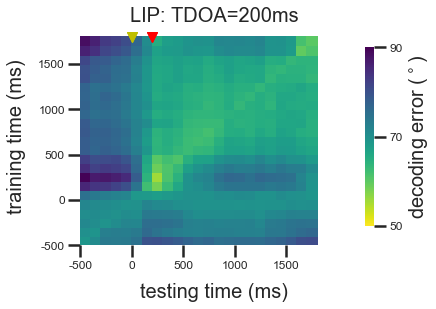

In [194]:
H = [pd.DataFrame(heatmaps_lip_200[x]) for x in range(len(heatmaps_lip_200))]
H_mean = pd.concat(H).groupby(level=0).mean()
heatmap(H_mean, 'LIP: TDOA=' +str(200)+'ms', dist_time=100)

## LIP, tdoa=300

In [196]:
heatmaps_lip_300=[]

for n_neuron,neuron_ in enumerate(lip_300.neuron.unique()):
    print(n_neuron, neuron_)
    ## get the neuron
    dfN = lip_300.loc[lip_300['neuron']==neuron_]
    ## column of times centered to stim onset
    dfN['times_centered'] = dfN['times'] - dfN['fixationtime']

    #cross-decoding for 1 neuron
    ### empty matrix to append the cross temporal decoding
    all_times = np.arange(-500,2100, 100)
    train_test = np.empty( (len(all_times), len(all_times) ) )
    train_test[:] = np.nan

    ### times I am interested in (no need to get more times)
    dfN = dfN.loc[(dfN['times_centered']>=-500) & (dfN['times_centered']<=2000) ]
    list_times = dfn.times_centered.unique()
    list_times_sorted =np.sort(list_times)
    list_times_sorted

    for training_time in list_times_sorted:
        #print(training_time)
        dfn_train = dfN.loc[(dfN['times_centered']==training_time), ['firing', 'target_angle']]         
        dfn_train = dfn_train.loc[dfn_train.iloc[:,0]<9999] ###Take off nans
        paralel_train = [dfn_train for i in range(len(list_times_sorted))]

        paralel_test = []
        for times_testing in list_times_sorted:
            dfn_test =dfN.loc[(dfN['times_centered']==times_testing), ['firing', 'target_angle']]
            dfn_test = dfn_test.loc[dfn_test.iloc[:,0]<9999] ###Take off nans
            paralel_test.append(dfn_test)

        cross_temp = Parallel(n_jobs = numcores)(delayed(decoder)(training, testing)  for training, testing in zip(paralel_train, paralel_test) )   #### reconstruction standard (paralel)

        idx_append_row = np.where(training_time == all_times )[0][0]
        idx_append_col1 = np.where(list_times_sorted[0] == all_times)[0][0]
        idx_append_col2 = np.where(list_times_sorted[-1] == all_times)[0][0]
        train_test[idx_append_row, idx_append_col1:idx_append_col2+1] = cross_temp
    ##
    heatmaps_lip_300.append(train_test)

0 1364705


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


1 1365201
2 1365301
3 1365501
4 1365701
5 1365802
6 1365902
7 1366002
8 1366101
9 189139306
10 1891406
11 1891407
12 189141804
13 1891421
14 1891436
15 189144701
16 189144904
17 189147105
18 189150602
19 189151102
20 189152601
21 189154404
22 189154602
23 189155501
24 189156205
25 189157901
26 189158601
27 1891598
28 189160302
29 189160702
30 189161604
31 1891626
32 189163101
33 189163701
34 189164103
35 189164404
36 189164801
37 189164803
38 189165003
39 1891653
40 1892063
41 189207101
42 189207501
43 189208001


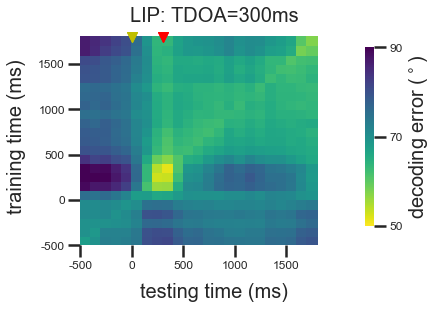

In [197]:
H = [pd.DataFrame(heatmaps_lip_300[x]) for x in range(len(heatmaps_lip_300))]
H_mean = pd.concat(H).groupby(level=0).mean()
heatmap(H_mean, 'LIP: TDOA=' +str(300)+'ms', dist_time=200)

## LIP, tdoa=900

In [198]:
heatmaps_lip_900=[]

for n_neuron,neuron_ in enumerate(lip_900.neuron.unique()):
    print(n_neuron, neuron_)
    ## get the neuron
    dfN = lip_900.loc[lip_900['neuron']==neuron_]
    ## column of times centered to stim onset
    dfN['times_centered'] = dfN['times'] - dfN['fixationtime']

    #cross-decoding for 1 neuron
    ### empty matrix to append the cross temporal decoding
    all_times = np.arange(-500,2100, 100)
    train_test = np.empty( (len(all_times), len(all_times) ) )
    train_test[:] = np.nan

    ### times I am interested in (no need to get more times)
    dfN = dfN.loc[(dfN['times_centered']>=-500) & (dfN['times_centered']<=2000) ]
    list_times = dfn.times_centered.unique()
    list_times_sorted =np.sort(list_times)
    list_times_sorted

    for training_time in list_times_sorted:
        #print(training_time)
        dfn_train = dfN.loc[(dfN['times_centered']==training_time), ['firing', 'target_angle']]         
        dfn_train = dfn_train.loc[dfn_train.iloc[:,0]<9999] ###Take off nans
        paralel_train = [dfn_train for i in range(len(list_times_sorted))]

        paralel_test = []
        for times_testing in list_times_sorted:
            dfn_test =dfN.loc[(dfN['times_centered']==times_testing), ['firing', 'target_angle']]
            dfn_test = dfn_test.loc[dfn_test.iloc[:,0]<9999] ###Take off nans
            paralel_test.append(dfn_test)

        cross_temp = Parallel(n_jobs = numcores)(delayed(decoder)(training, testing)  for training, testing in zip(paralel_train, paralel_test) )   #### reconstruction standard (paralel)

        idx_append_row = np.where(training_time == all_times )[0][0]
        idx_append_col1 = np.where(list_times_sorted[0] == all_times)[0][0]
        idx_append_col2 = np.where(list_times_sorted[-1] == all_times)[0][0]
        train_test[idx_append_row, idx_append_col1:idx_append_col2+1] = cross_temp
    ##
    heatmaps_lip_900.append(train_test)

0 1364705


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


1 1365201
2 1365301
3 1365501
4 1365701
5 1365802
6 1365902
7 1366002
8 1366101
9 189139306
10 1891406
11 1891407
12 189141804
13 1891421
14 1891436
15 189144701
16 189144904
17 189147105
18 189150602
19 189151102
20 189152601
21 189154404
22 189154602
23 189155501
24 189156205
25 189157901
26 189158601
27 1891598
28 189160302
29 189160702
30 189161604
31 1891626
32 189163101
33 189163701
34 189164103
35 189164404
36 189164801
37 189164803
38 189165003
39 1891653
40 1892063
41 189207101
42 189207501
43 189208001


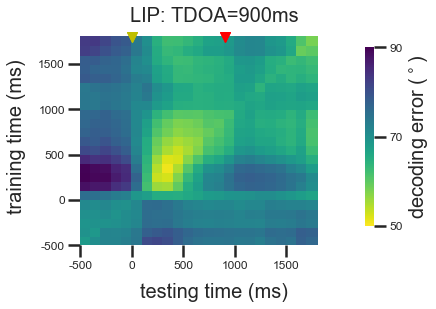

In [199]:
H = [pd.DataFrame(heatmaps_lip_900[x]) for x in range(len(heatmaps_lip_900))]
H_mean = pd.concat(H).groupby(level=0).mean()
heatmap(H_mean, 'LIP: TDOA=' +str(900)+'ms', dist_time=800)

## Subpopulation analysis

In [255]:
def parabola(x, a, b, c):
    return a*x**2 + b*x + c

def line(x, b, c):
    return b*x + c

######
def fit_parabola(x, parms):
    return parms[0]*x**2 + parms[1]*x + parms[2]


def fit_line(x, parms):
    return parms[0]*x + parms[1]

In [256]:
def Cross_validate_model(x_data, y_data, model, fit_model):
    loo = LeaveOneOut()
    errors_=[]
    for train_index, test_index in loo.split(x_data):
        x_train, x_test = x_data[train_index], x_data[test_index]
        y_train, y_test = y_data[train_index], y_data[test_index]
        ##
        popt, pcov = curve_fit(model, x_train, y_train, method='dogbox', maxfev=1000 )
        y_fit = fit_model(x_test, popt)
        ##
        E = (y_fit -y_test)**2
        errors_.append(E)
    ##
    errors_model_estimation = np.sum(np.array(errors_))
    return errors_model_estimation
        

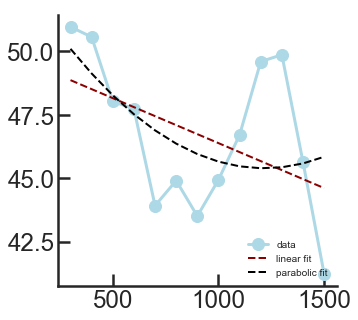

0
177.54974498182037 123.89671159406313
linear negative




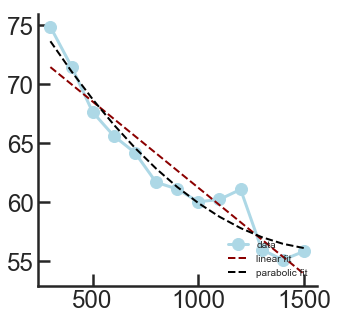

1
34.84663221226954 62.5119641694657
parabola positive




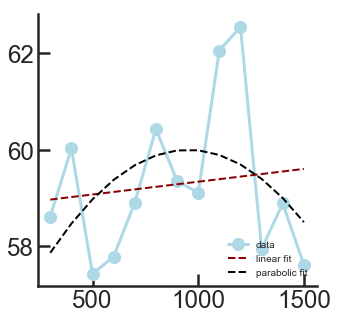

2
40.67150348593886 42.990554012847376
parabola negative




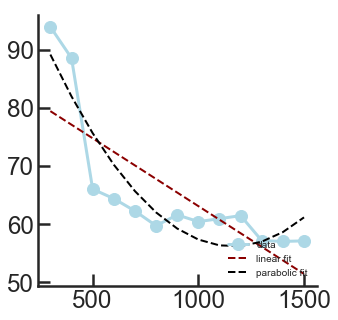

3
547.0794104127866 1079.8950266618212
parabola positive




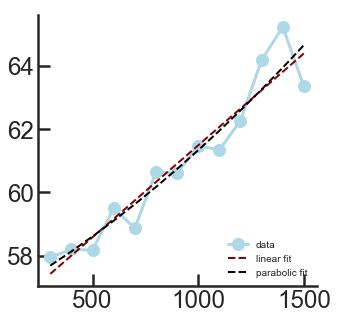

4
14.259152301544656 9.602501104660545
linear positive




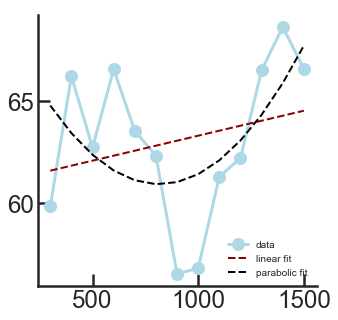

5
252.5987246694779 219.41852984982128
linear positive




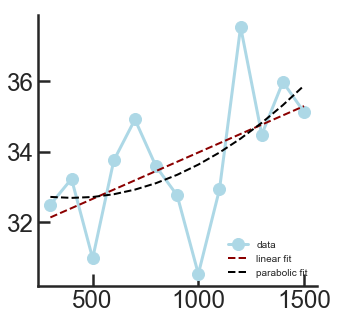

6
44.728089224647626 40.81522220859134
linear positive




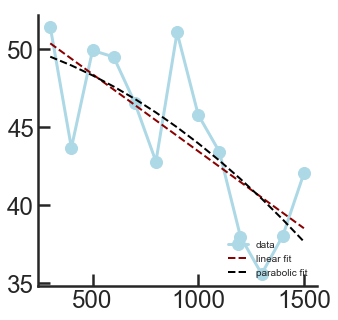

7
287.35212929379014 209.2868826063889
linear negative




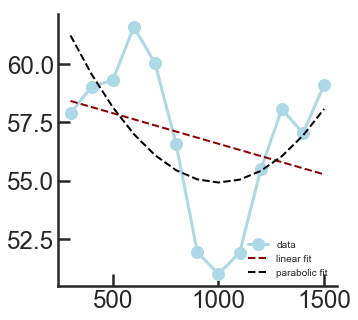

8
163.0626631557728 163.99056455533133
parabola positive




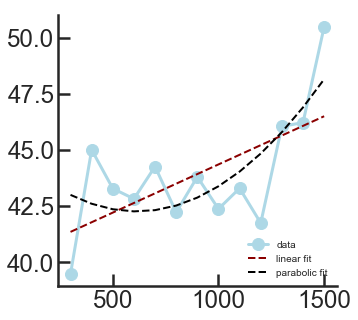

9
111.98176946098945 82.76682921967989
linear positive




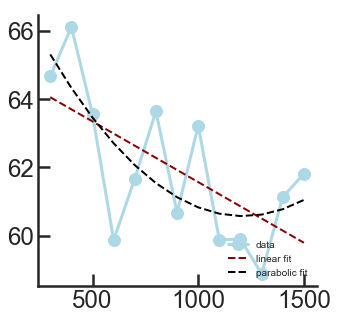

10
42.312326285692386 47.81931704792356
parabola positive




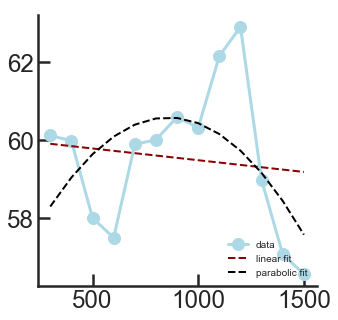

11
56.95423797087832 60.250742946923395
parabola negative




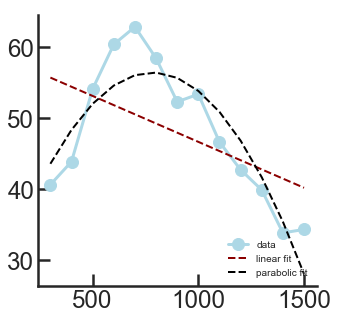

12
438.01456311924 1248.0795976588656
parabola negative




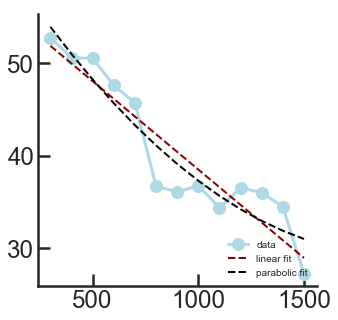

13
164.56634742955748 131.3735350023892
linear negative




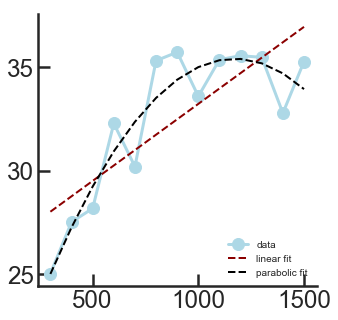

14
35.43500898371169 83.38563493281879
parabola negative




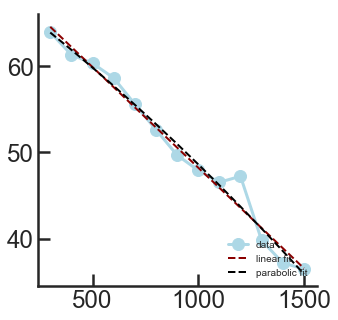

15
30.485778242024345 30.840379326280633
parabola negative




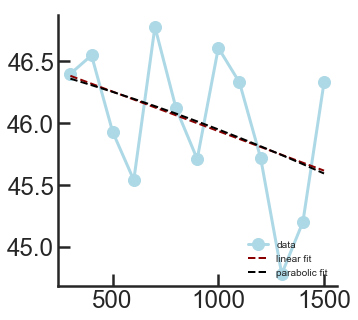

16
6.547476609320226 4.904119061917485
linear negative




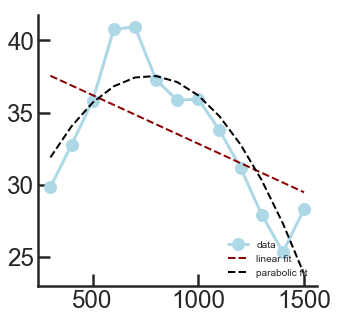

17
168.49639365824453 307.4880340947395
parabola negative




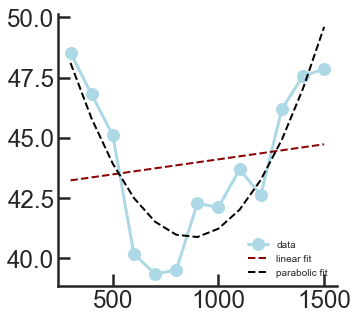

18
46.108529689088996 187.5684571813814
parabola positive




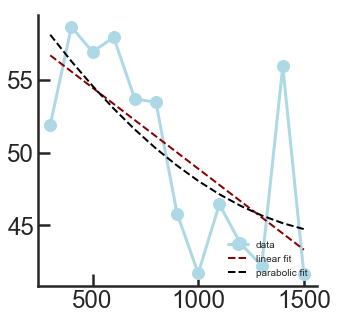

19
594.4293690360997 431.47095201545494
linear negative




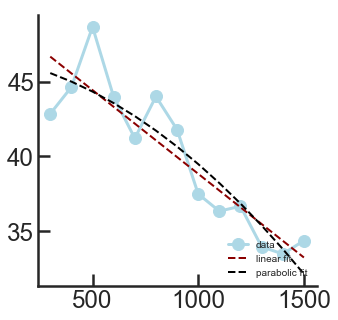

20
107.2132482689918 82.69366498013538
linear negative




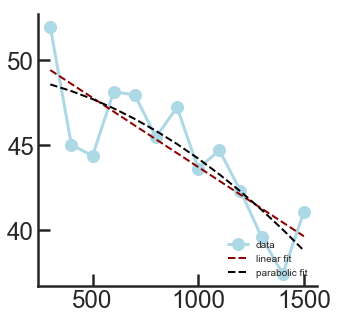

21
137.78374477931297 91.38217175709619
linear negative




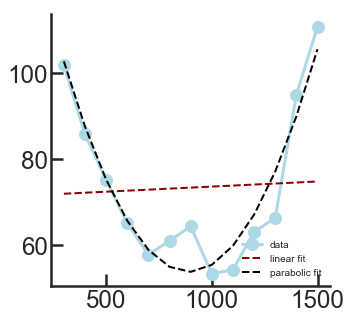

22
631.0514350292881 6987.588097506998
parabola positive




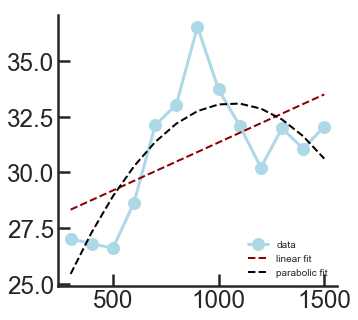

23
66.58786895264831 93.68644029987105
parabola negative




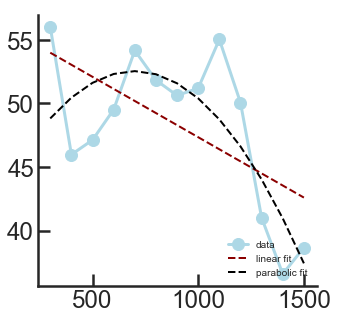

24
432.7541182055058 424.3526848463089
linear negative




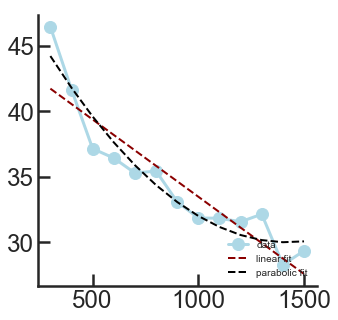

25
49.44701682218306 78.94998949388439
parabola positive




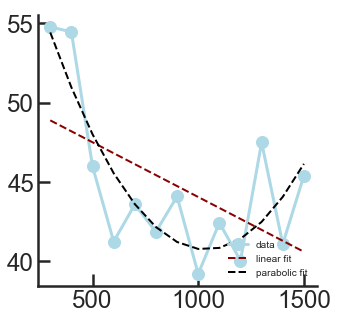

26
132.11779351920322 322.9793328407716
parabola positive




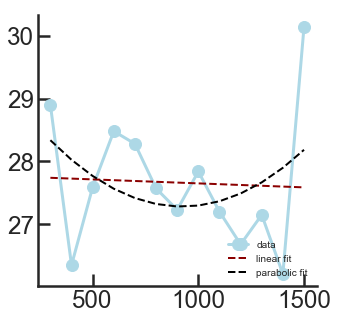

27
32.49418126434591 24.386486269857688
linear negative




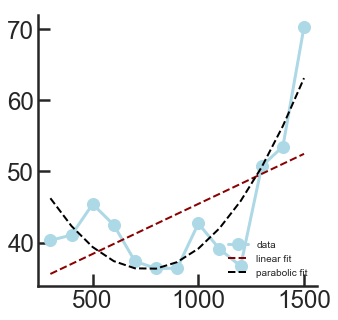

28
622.1748248832918 1153.825202784496
parabola positive




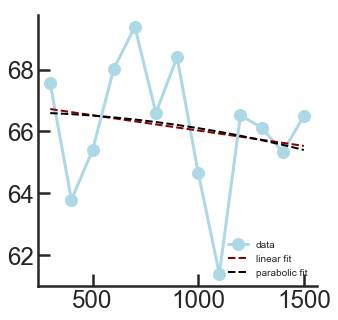

29
81.41298327833285 67.52354605983759
linear negative




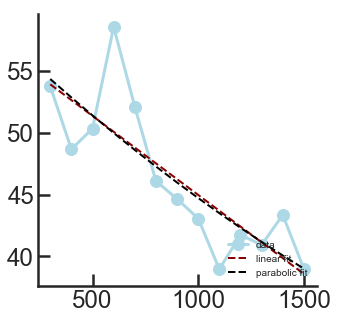

30
209.7354691025776 192.2124044478208
linear negative




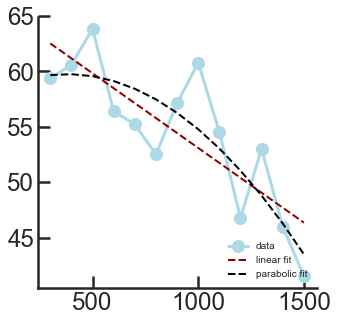

31
210.77685309242304 242.5535636953826
parabola negative




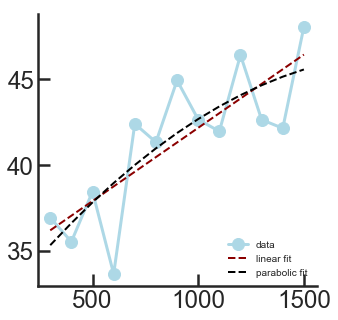

32
133.1434428212084 105.61643920470236
linear positive




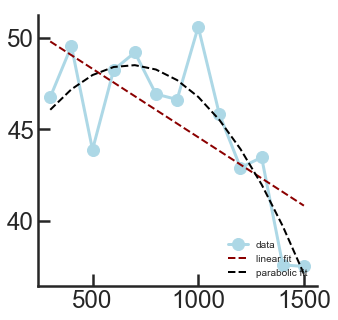

33
76.4911251246526 153.23156724637232
parabola negative




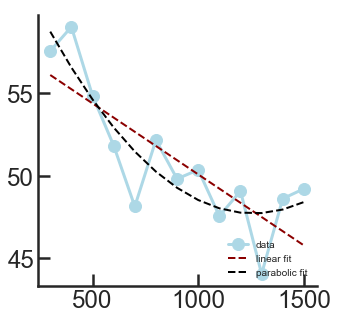

34
70.68735938184403 107.927559686334
parabola positive




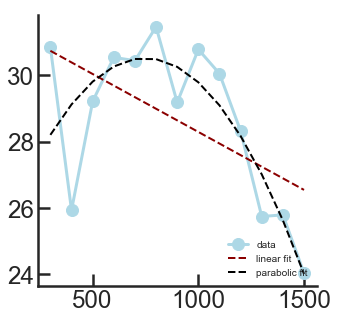

35
58.097929697301986 73.96871635396255
parabola negative




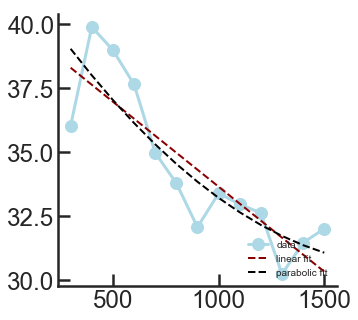

36
66.9385428811382 43.14901338713096
linear negative




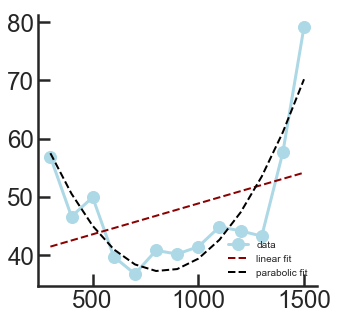

37
644.6786570614854 2267.5597982646577
parabola positive




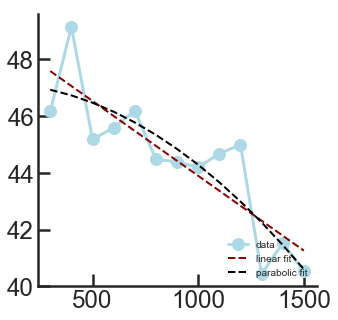

38
29.66369056667564 29.11402703662055
linear negative




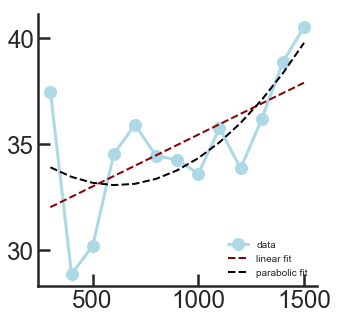

39
134.60889105580367 126.039291951596
linear positive




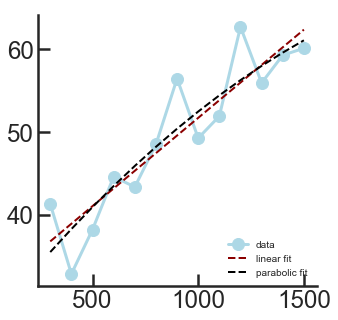

40
365.615446089081 263.3170726944513
linear positive




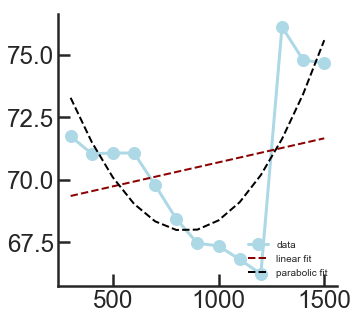

41
87.16927292214211 167.42058166308362
parabola positive




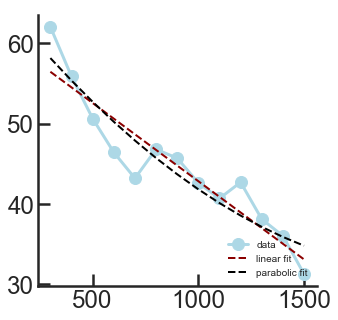

42
208.00933875993377 157.04785905069562
linear negative




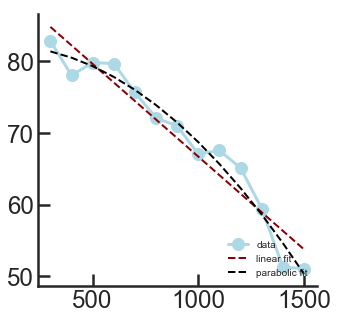

43
75.1680923123396 137.53900803255078
parabola negative




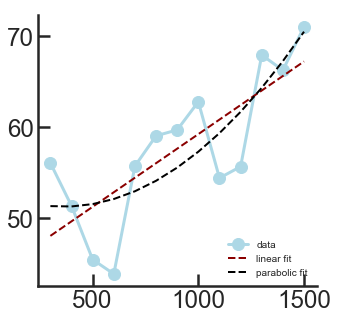

44
458.61141896403916 472.7188416867075
parabola positive




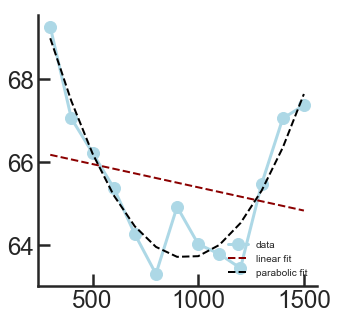

45
6.572585127927962 58.08086613337822
parabola positive




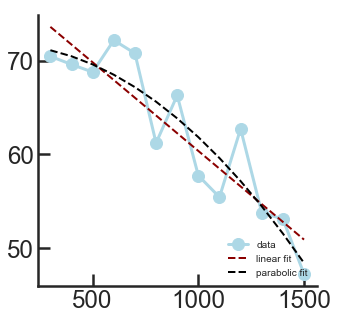

46
178.5039627597451 204.1306729241513
parabola negative




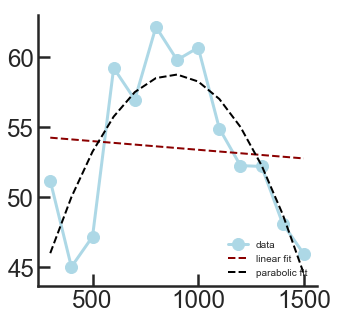

47
287.3275996721338 597.6624864245755
parabola negative




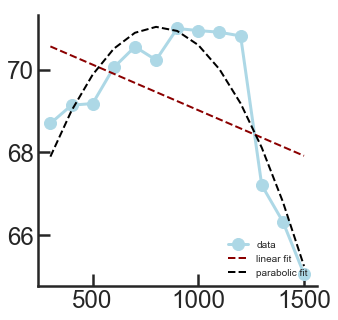

48
11.459481638475086 54.39195575505423
parabola negative




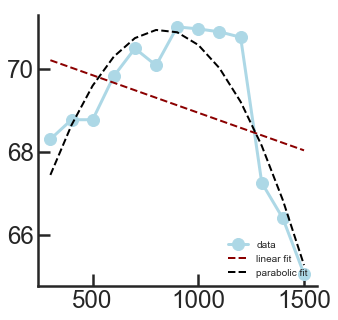

49
11.893273793381885 58.18886246705941
parabola negative




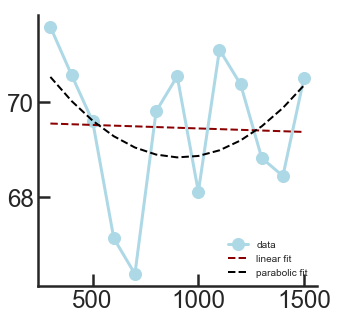

50
40.33619280275716 41.534413807301036
parabola positive




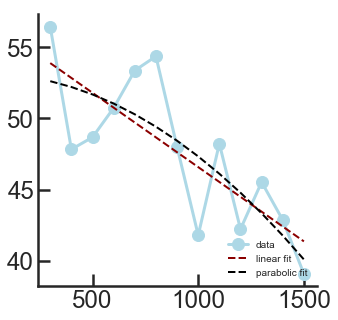

51
233.61055338183715 181.79621676135784
linear negative




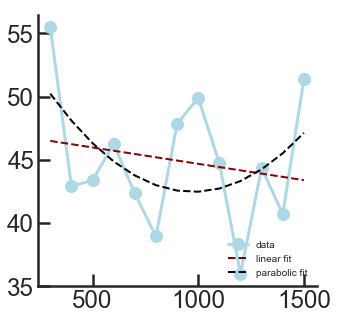

52
534.3140273443818 508.96889003601234
linear negative




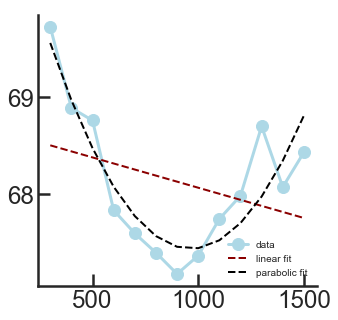

53
2.241209784604165 8.716136007734372
parabola positive




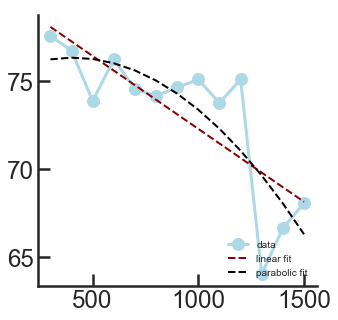

54
110.68201850274983 112.22463762958618
parabola negative




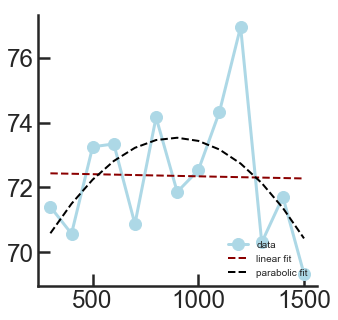

55
55.96317381685907 72.58304325675802
parabola negative




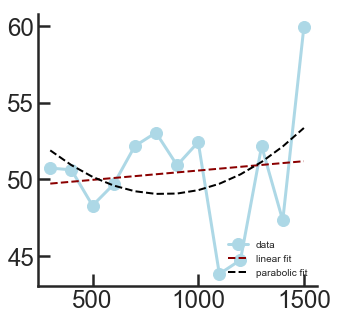

56
386.94486420740105 302.4495973315803
linear positive




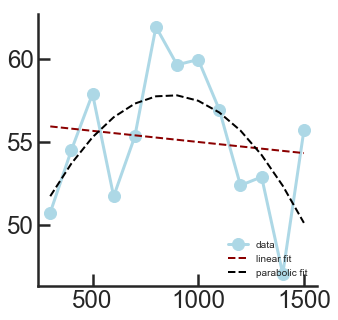

57
294.76628002192956 295.97777462917884
parabola negative




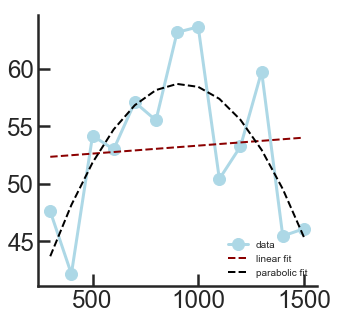

58
399.5444557738924 789.6097797578716
parabola negative




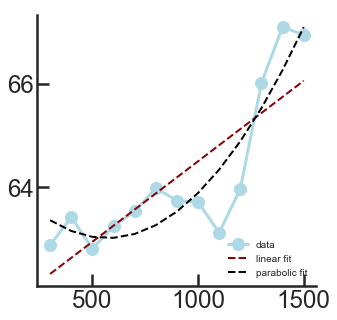

59
7.343992747799488 12.824623470928397
parabola positive




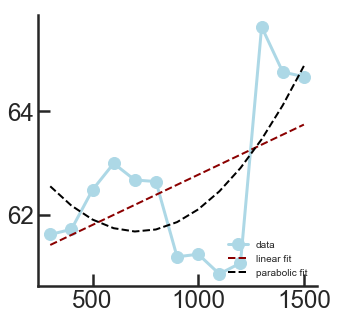

60
26.71278256409661 29.963917872857433
parabola positive




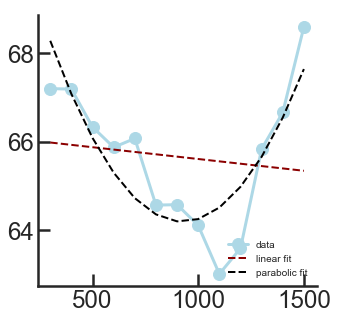

61
18.1435230000804 47.38721073214229
parabola positive




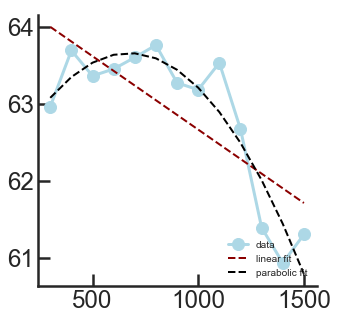

62
3.231840347308595 7.57945950557347
parabola negative




In [316]:
parab_n_100=[]
linear_n_100=[]

total=len(heatmaps_pfc_100)

for i in range(total):
    n1 = heatmaps_pfc_100[i]
    data_ = n1[16, 8:21]
    x_data = np.arange(300, 1600, 100)
    y_data=data_

    plt.figure(figsize=(5, 5))      
    #############################
    plt.plot(x_data, y_data, '-', color='lightblue', marker='o', label='data')
    #############################    
    ###############################
    poptl, pcov = curve_fit(line, x_data, y_data, method='dogbox', maxfev=1000 )
    y_fit = [poptl[0]*x + poptl[1] for x in x_data]
    plt.plot(x_data, y_fit, '--', color='darkred', linewidth=2, label='linear fit')

    popt, pcov = curve_fit(parabola, x_data, y_data, method='dogbox',  maxfev=1000 )
    y_fit = [popt[0]*x**2 + popt[1]*x + popt[2] for x in x_data]
    plt.plot(x_data, y_fit, 'k--', linewidth=2, label='parabolic fit')
    ##############################
    ##############################
    plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
    plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
    plt.gca().get_xaxis().tick_bottom()                                                                                         
    plt.gca().get_yaxis().tick_left()
    plt.gca().tick_params(direction='in') #direction
    plt.legend(loc=4, frameon=False, prop={'size': 10})

    plt.show()

    parab_ssq = Cross_validate_model(x_data, y_data, parabola, fit_parabola)
    line_ssq = Cross_validate_model(x_data, y_data, line, fit_line)
    print(i)
    print(parab_ssq, line_ssq)
    if parab_ssq<line_ssq:
        if popt[0]>0:
            print('parabola positive')
            #parab_p.append(i)
        else:
            print('parabola negative')
            parab_n_100.append(i)
    else:
        linear.append(i)
        if poptl[0]>0:
            print('linear positive')
            #linear_p.append(i)
        else:
            print('linear negative')
            linear_n_100.append(i)
                  
    #
    print('')
    print('')
    
######
######

In [317]:
## percentage of each
print(int(len(parab_n_100)/total*100), int(len(linear_n_100)/total*100))

31 25


In [330]:
parb_neg_neurons_100 = pfc_100.neuron.unique()[parab_n_100]
parb_neg_neurons_100

array([  1367903,   1372402, 189168701, 189171003, 189171602, 189173101,
       189176501, 189179702, 189181001,   1891819,   1891857, 189188901,
       189189601, 189191601, 189191602,   1891935, 189194301, 189196301,
       189196401, 189210901], dtype=int64)

In [329]:
linear_neg_neurons_100 = pfc_100.neuron.unique()[linear_n_100]
linear_neg_neurons_100

array([  1367701,   1371202, 189169502, 189172801, 189174201, 189175201,
       189175801, 189176901,   1891783, 189179002,   1891793, 189182202,
       189182901, 189184601, 189192001, 189192201], dtype=int64)

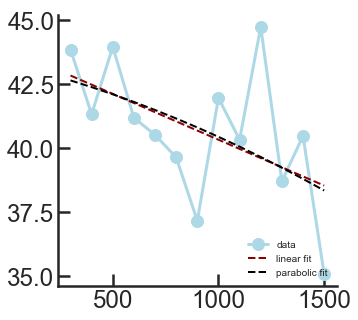

0
127.92762760186457 92.51312721228055
linear negative




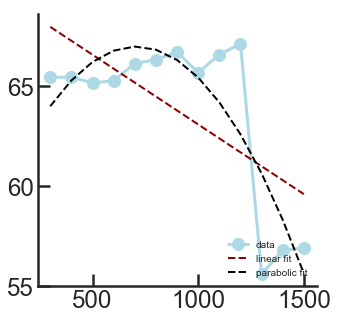

1
98.12253634556555 178.75160918752232
parabola negative




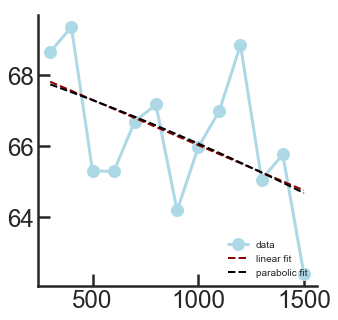

2
67.70060930221497 50.080492593978164
linear negative




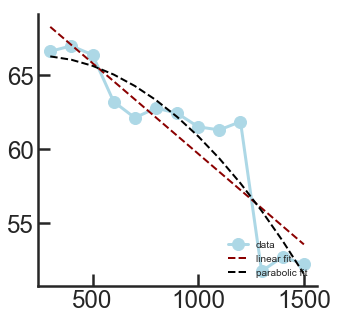

3
71.48487305979995 91.21306132668713
parabola negative




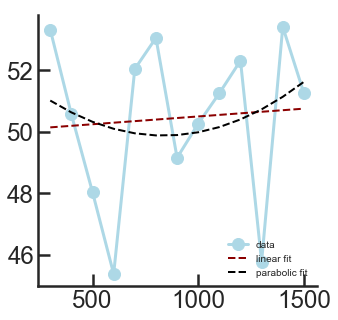

4
134.3362325867828 123.11633404006105
linear positive




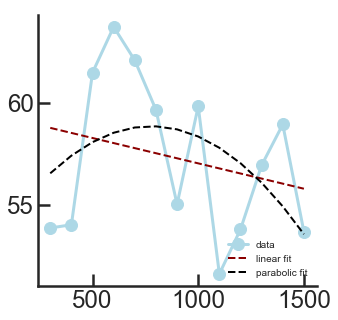

5
242.78515219698926 244.3099796723111
parabola negative




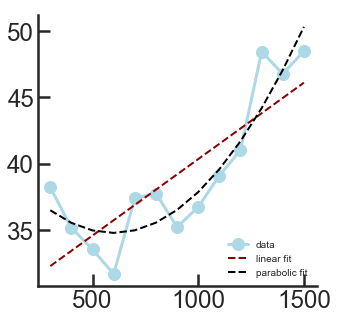

6
89.85909637572976 187.49001356760473
parabola positive




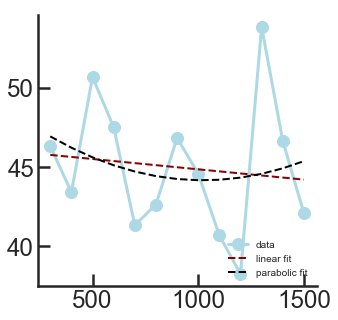

7
333.1933071912187 298.1652010019345
linear negative




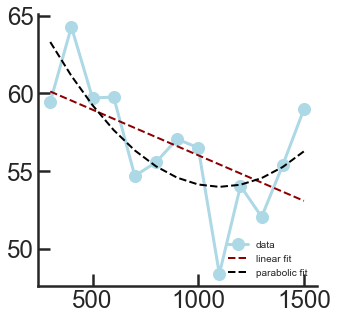

8
193.3841247396181 195.68975406781368
parabola positive




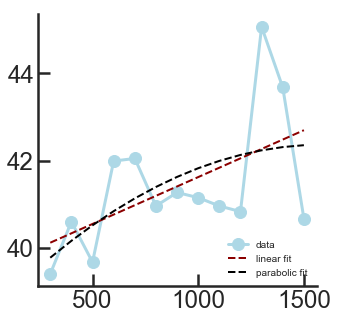

9
37.072054624224094 30.245761533633925
linear positive




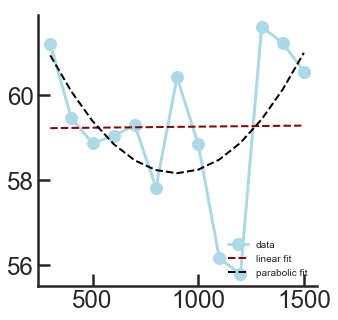

10
40.83525620152729 56.62366972064022
parabola positive




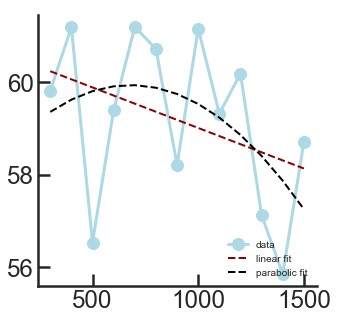

11
53.515574378299334 47.33738270395795
linear negative




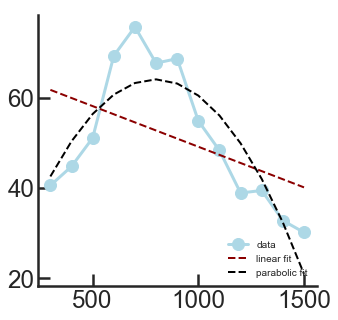

12
1157.770425553397 3155.891773424948
parabola negative




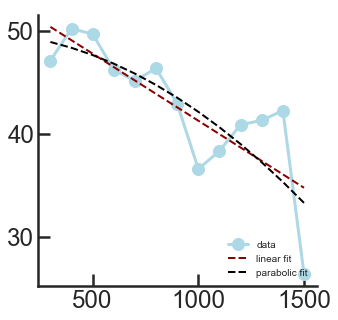

13
407.02583678607994 288.42160790637763
linear negative




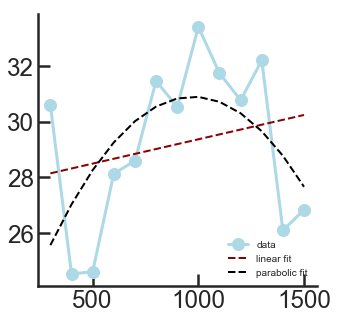

14
181.1570630296455 147.47356182621675
linear positive




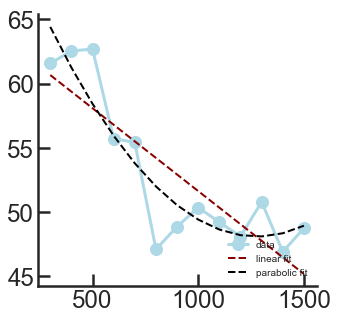

15
122.19373332210034 171.2137522073542
parabola positive




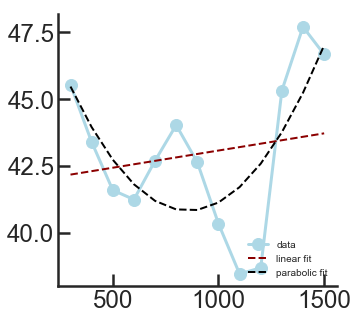

16
76.28313372324038 141.93605414086736
parabola positive




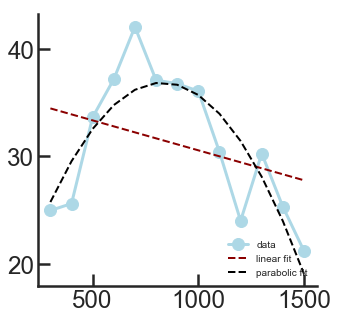

17
210.81314453479143 674.6662703608986
parabola negative




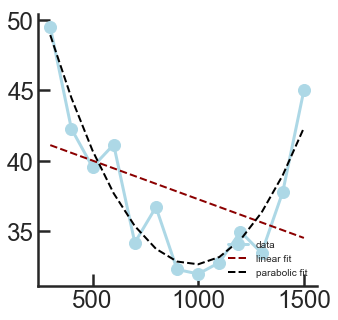

18
90.0318382425266 490.7916402238521
parabola positive




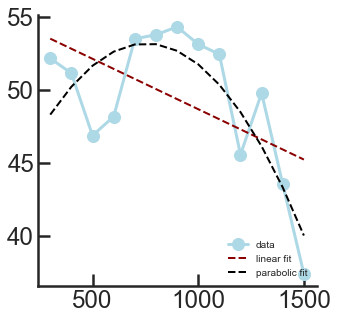

19
198.9517728076748 308.80580375908517
parabola negative




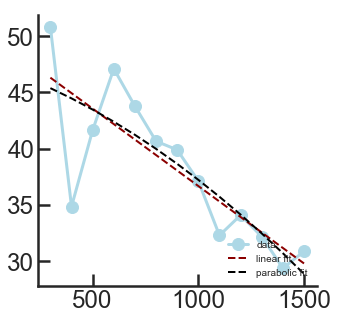

20
386.1477384059166 275.94764120902397
linear negative




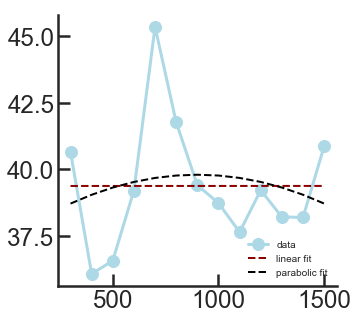

21
124.41470932286173 95.32402834092967
linear positive




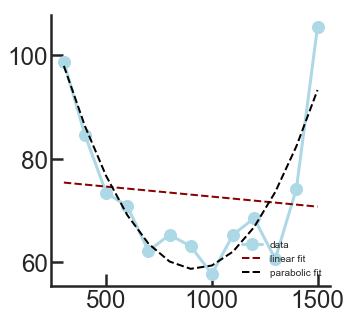

22
1128.2759471074714 4387.5308314832
parabola positive




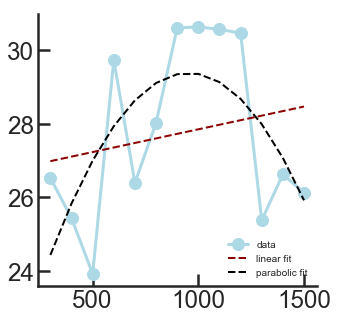

23
67.96410509220988 91.16891888537735
parabola negative




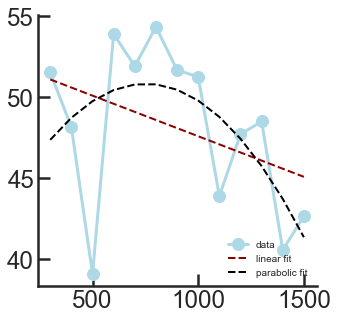

24
349.38663792236775 362.1056568655113
parabola negative




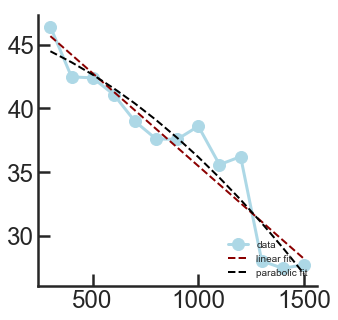

25
69.95457998767219 62.440447206090646
linear negative




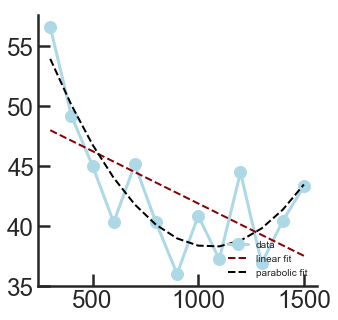

26
151.17717358257076 372.1404539958306
parabola positive




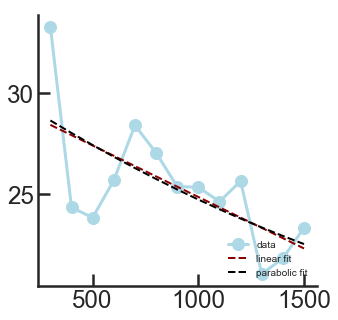

27
163.7697515851069 107.32092819673714
linear negative




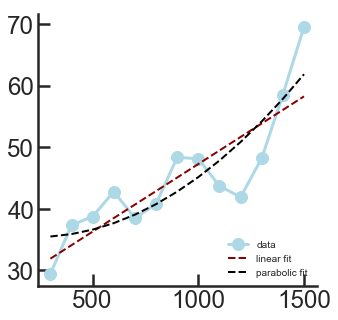

28
698.7081686175516 549.4115798051577
linear positive




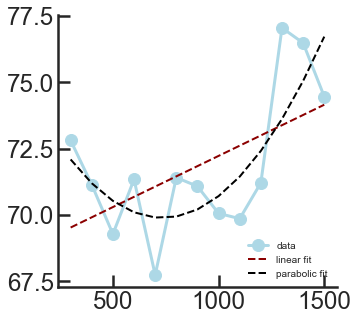

29
65.96523946982651 89.76911962521564
parabola positive




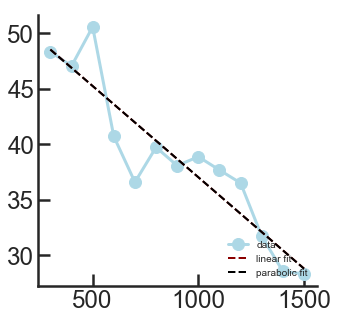

30
123.80976884603135 115.24738027124867
linear negative




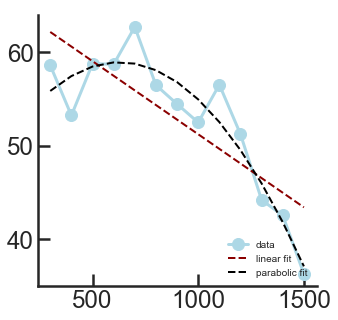

31
142.06360065510566 366.02231558105825
parabola negative




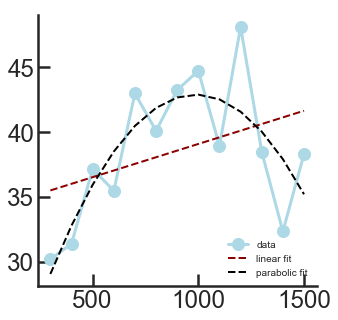

32
220.96600801606803 433.45162591116156
parabola negative




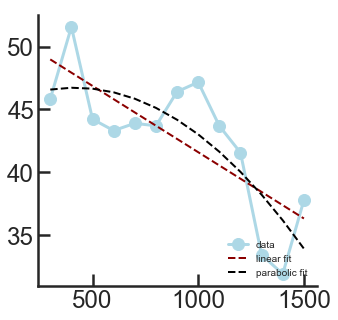

33
249.6621986847016 220.15124970005536
linear negative




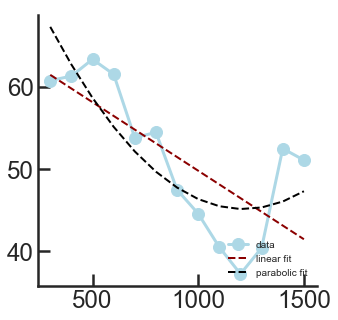

34
604.8386195652706 657.1772074273749
parabola positive




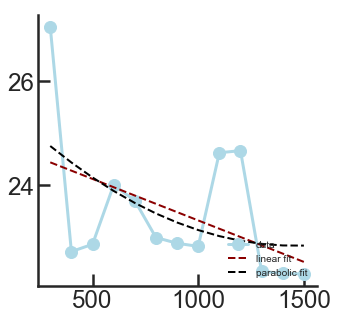

35
40.92228487494164 27.243576762651774
linear negative




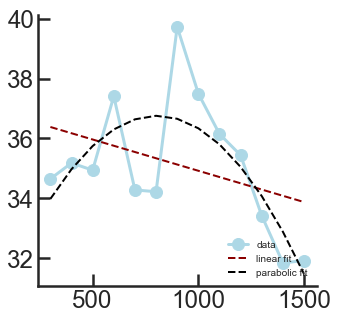

36
41.26413424602242 68.83217831235044
parabola negative




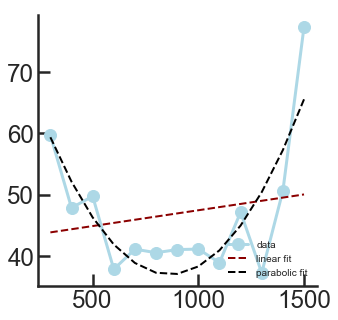

37
1073.0283811378017 2484.3263806613922
parabola positive




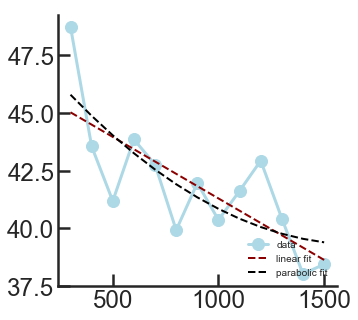

38
81.23625175437579 60.39845024776957
linear negative




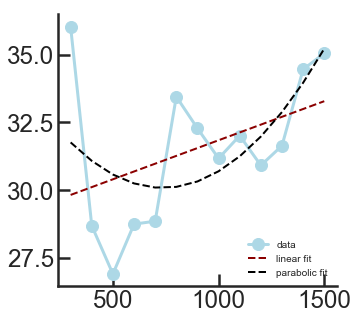

39
140.70266643221632 125.54633692077604
linear positive




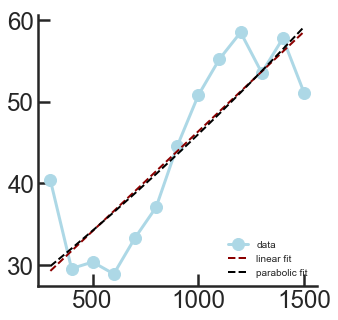

40
1098.622614344274 657.4833669382738
linear positive




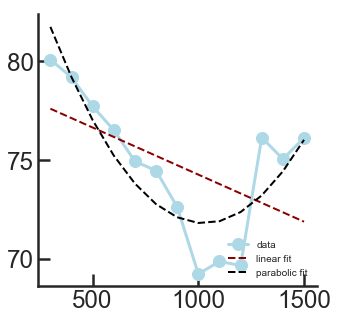

41
59.22913841345021 154.96690625685363
parabola positive




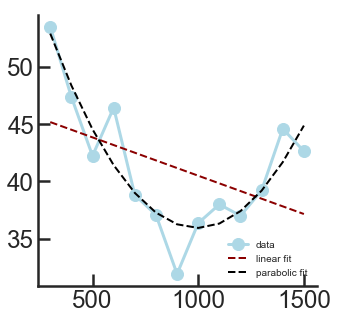

42
114.09557350027055 467.2795557691216
parabola positive




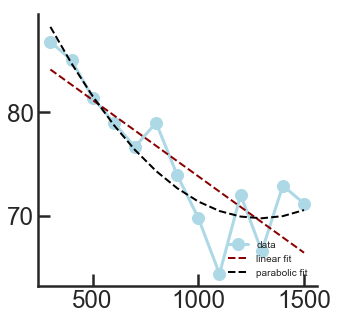

43
136.4169571362461 228.4713158319975
parabola positive




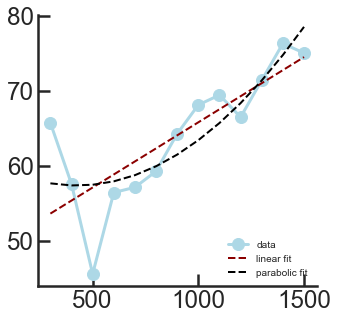

44
612.9473173321735 551.8177673613354
linear positive




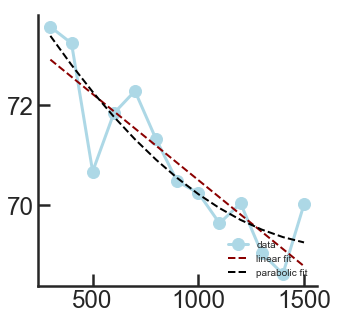

45
9.9147742322466 10.02528355471743
parabola positive




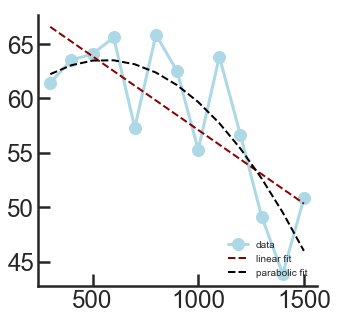

46
334.1464508678655 359.4771855189306
parabola negative




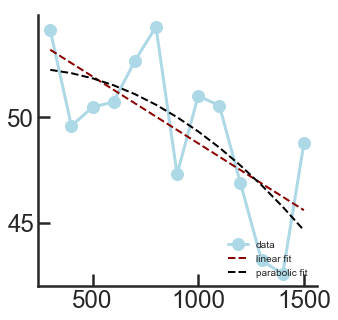

47
185.7660378962361 125.19115930199462
linear negative




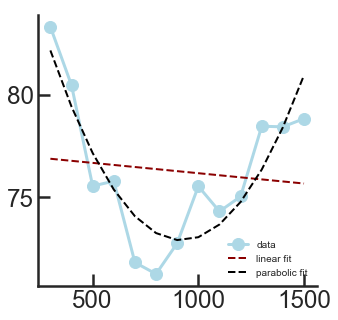

48
59.73283555772938 221.55750981966932
parabola positive




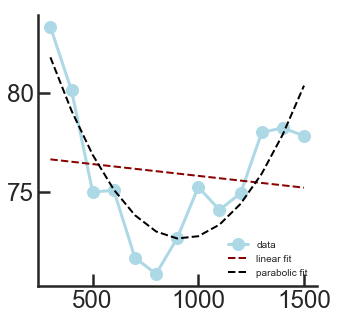

49
74.33793171917432 220.32895971891344
parabola positive




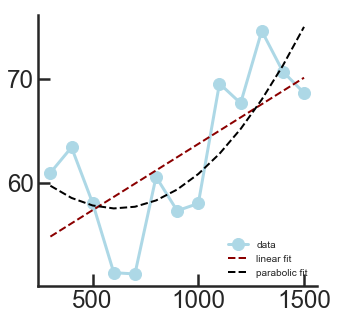

50
492.6842719936492 499.9927449353058
parabola positive




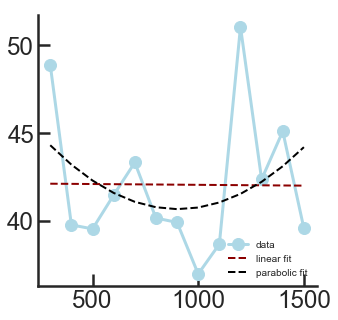

51
382.2139365551179 296.51879847372714
linear negative




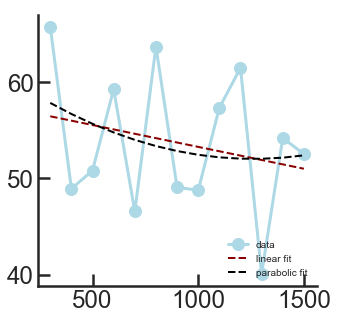

52
1082.2434686298195 887.0559616192678
linear negative




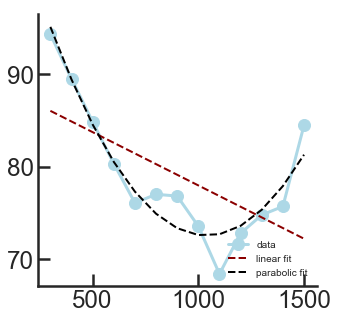

53
109.3762269342372 641.4403271855845
parabola positive




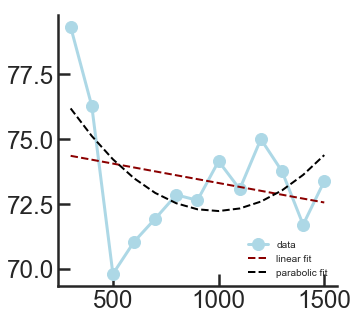

54
108.88639073401536 106.46445477793822
linear negative




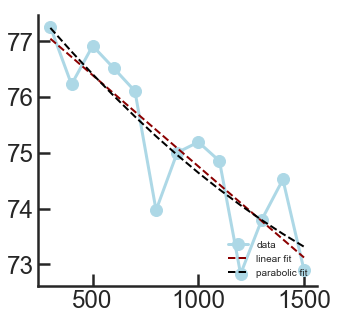

55
9.541411106287935 8.279217886323345
linear negative




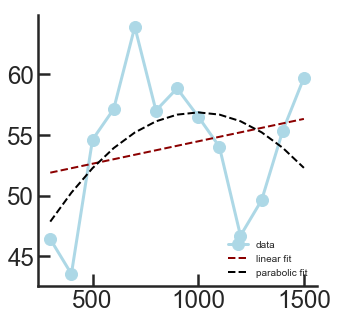

56
644.9564555348979 559.80512706298
linear positive




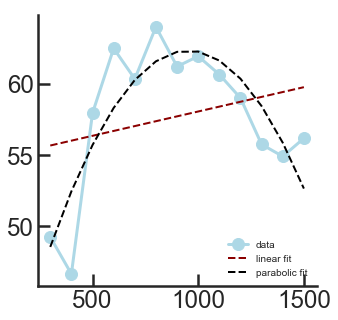

57
175.6609072208705 444.17833746045153
parabola negative




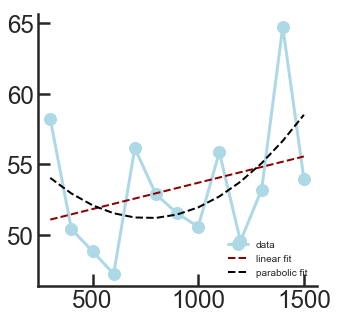

58
421.2793829477505 366.06082394774705
linear positive




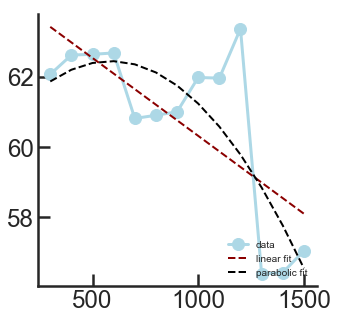

59
41.06575485093063 53.507588272572555
parabola negative




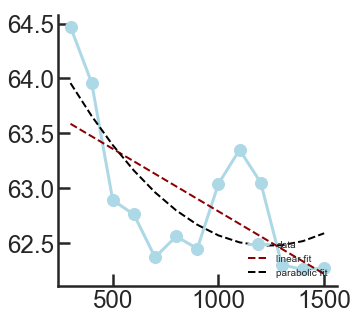

60
4.8666355201137295 4.686760294195759
linear negative




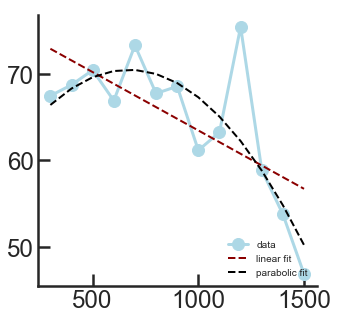

61
383.3513157602718 637.7621105155954
parabola negative




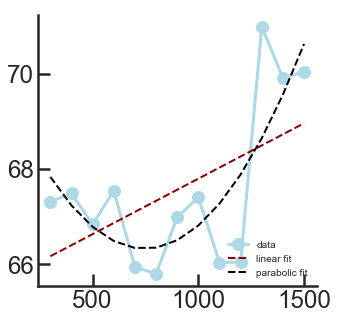

62
20.56628605866838 34.800555869945526
parabola positive




In [315]:
parab_n_200=[]
linear_n_200=[]

total=len(heatmaps_pfc_200)

for i in range(total):
    n1 = heatmaps_pfc_200[i]
    data_ = n1[16, 8:21]
    x_data = np.arange(300, 1600, 100)
    y_data=data_

    plt.figure(figsize=(5, 5))      
    #############################
    plt.plot(x_data, y_data, '-', color='lightblue', marker='o', label='data')
    #############################    
    ###############################
    poptl, pcov = curve_fit(line, x_data, y_data, method='dogbox', maxfev=1000 )
    y_fit = [poptl[0]*x + poptl[1] for x in x_data]
    plt.plot(x_data, y_fit, '--', color='darkred', linewidth=2, label='linear fit')

    popt, pcov = curve_fit(parabola, x_data, y_data, method='dogbox',  maxfev=1000 )
    y_fit = [popt[0]*x**2 + popt[1]*x + popt[2] for x in x_data]
    plt.plot(x_data, y_fit, 'k--', linewidth=2, label='parabolic fit')
    ##############################
    ##############################
    plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
    plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
    plt.gca().get_xaxis().tick_bottom()                                                                                         
    plt.gca().get_yaxis().tick_left()
    plt.gca().tick_params(direction='in') #direction
    plt.legend(loc=4, frameon=False, prop={'size': 10})

    plt.show()

    parab_ssq = Cross_validate_model(x_data, y_data, parabola, fit_parabola)
    line_ssq = Cross_validate_model(x_data, y_data, line, fit_line)
    print(i)
    print(parab_ssq, line_ssq)
    if parab_ssq<line_ssq:
        if popt[0]>0:
            print('parabola positive')
            #parab_p.append(i)
        else:
            print('parabola negative')
            parab_n_200.append(i)
    else:
        linear.append(i)
        if poptl[0]>0:
            print('linear positive')
            #linear_p.append(i)
        else:
            print('linear negative')
            linear_n_200.append(i)
                  
    #
    print('')
    print('')
    
######
######

In [319]:
## percentage of each
print(int(len(parab_n_200)/total*100), int(len(linear_n_200)/total*100))

23 28


In [328]:
parb_neg_neurons_200 = pfc_200.neuron.unique()[parab_n_200]
parb_neg_neurons_200

array([  1367802,   1369702,   1370002, 189168701, 189173101, 189174201,
       189176501, 189176901, 189179702, 189180001, 189182202, 189188901,
       189196301, 189209101, 189210001], dtype=int64)

In [327]:
linear_neg_neurons_200 = pfc_200.neuron.unique()[linear_n_200]
linear_neg_neurons_200

array([  1367701,   1367903,   1371202,   1372402, 189169502, 189175201,
       189177402,   1891783,   1891793, 189181001,   1891819, 189182901,
       189189601, 189192001, 189192201,   1891935, 189194301, 189209503],
      dtype=int64)

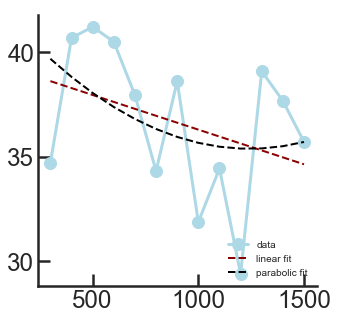

0
257.00399303940344 189.2629678715015
linear negative




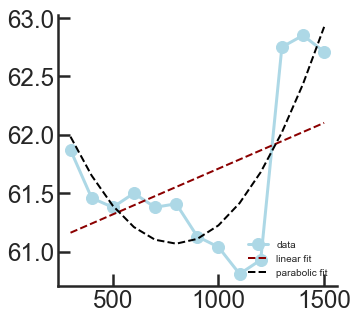

1
3.118153970487518 6.981759315642032
parabola positive




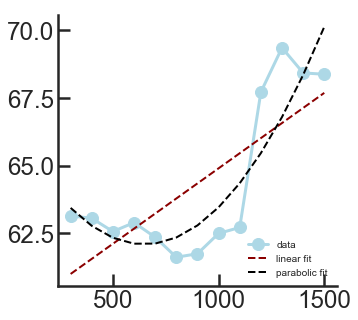

2
38.30943903931537 61.85252275417503
parabola positive




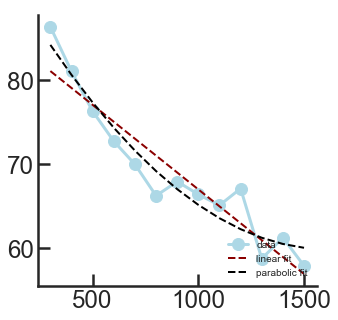

3
109.7675176893448 147.85718293554865
parabola positive




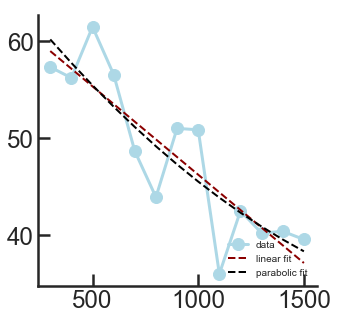

4
310.69174877929623 264.8029435869401
linear negative




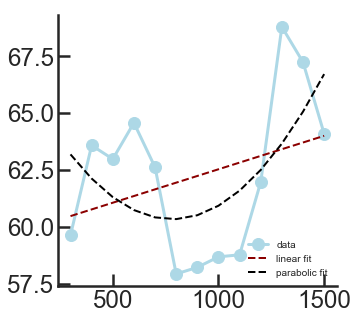

5
198.82098918671653 172.8101284441534
linear positive




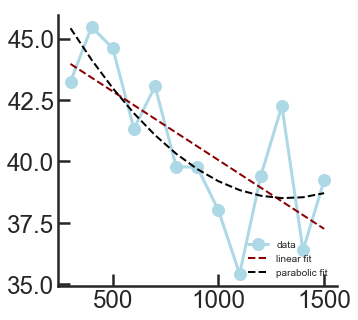

6
83.09206382714538 76.88476852294106
linear negative




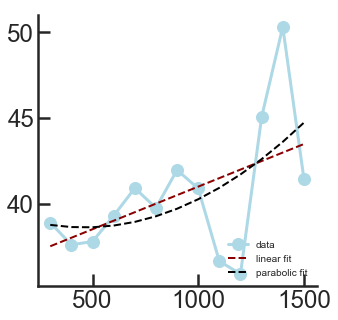

7
227.30045888217927 191.14225254287112
linear positive




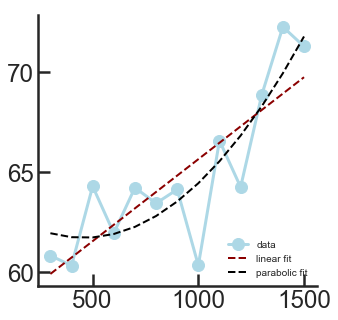

8
71.27971682738388 83.83060597575403
parabola positive




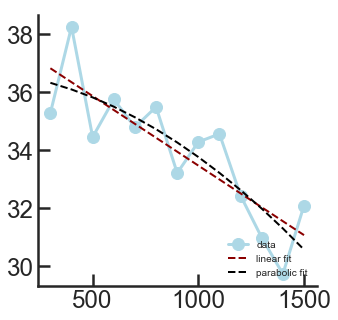

9
37.87633654771613 28.205762705157056
linear negative




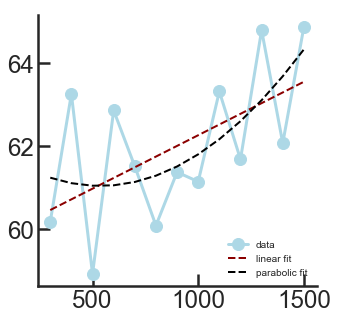

10
40.94180551861964 38.104477688224925
linear positive




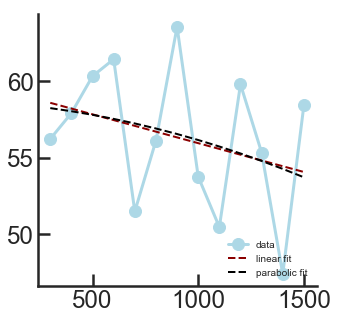

11
426.5248343132756 324.33898334379285
linear negative




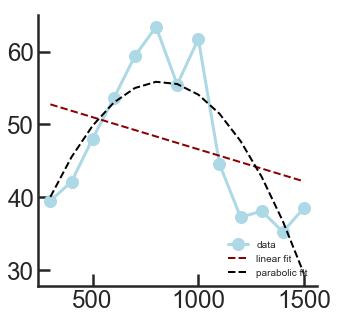

12
824.6391650763259 1511.659765838825
parabola negative




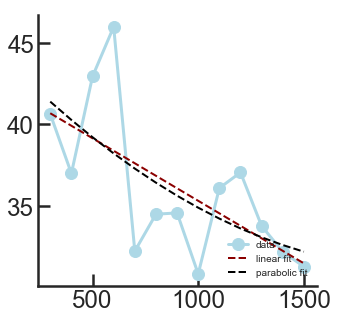

13
215.28558719588764 196.536223861349
linear negative




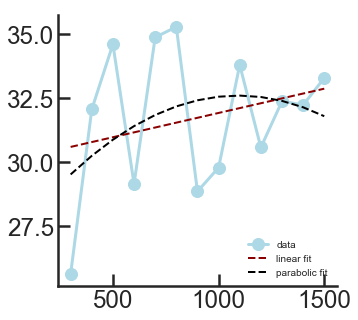

14
171.5286445587777 129.30061247251405
linear positive




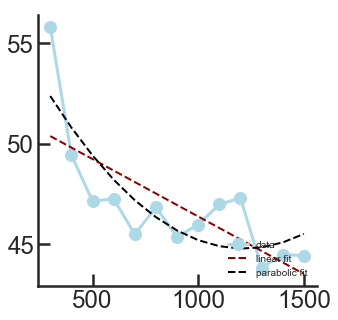

15
89.84396186025285 87.23203643769556
linear negative




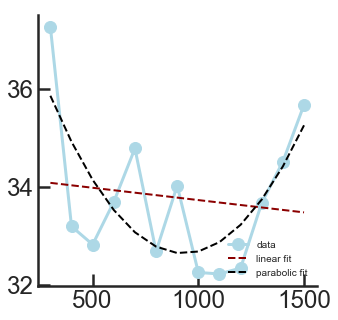

16
26.147668677550698 43.120830860447654
parabola positive




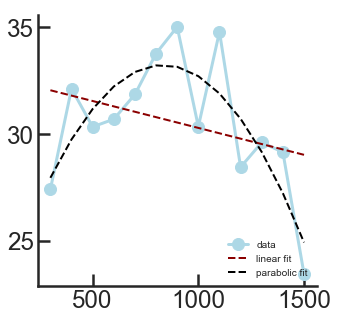

17
66.61233138501754 168.49930854274544
parabola negative




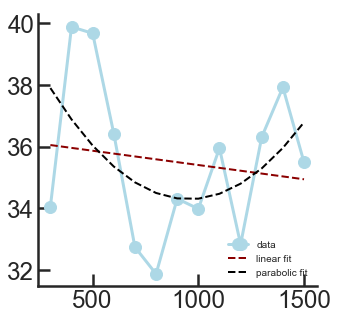

18
141.41866599542047 109.0174236012319
linear negative




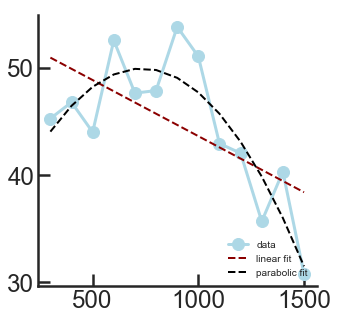

19
182.77455445835986 455.88520556354734
parabola negative




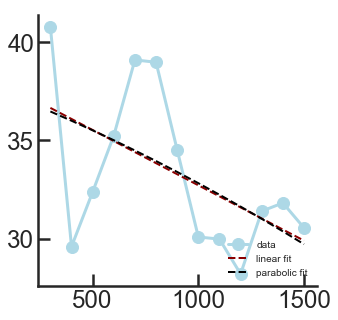

20
279.2862426546917 207.79372661759743
linear negative




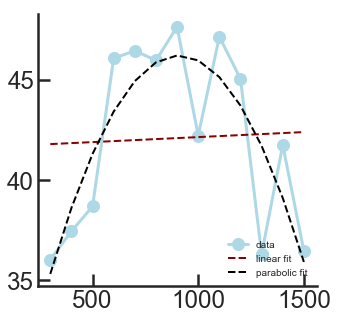

21
114.95351352044044 369.57021669049004
parabola negative




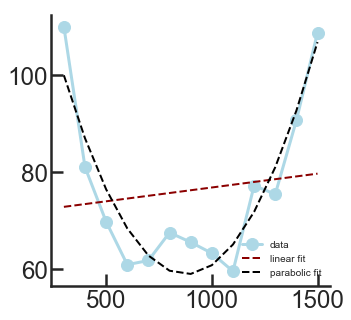

22
950.6465537958185 5888.693643976167
parabola positive




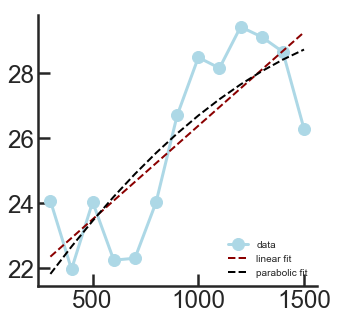

23
78.67254689123124 51.41287989945657
linear positive




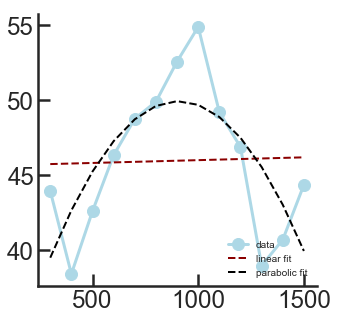

24
335.5942714684343 423.65072398578144
parabola negative




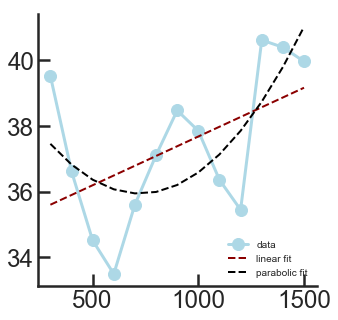

25
63.02275673873257 73.50576179374323
parabola positive




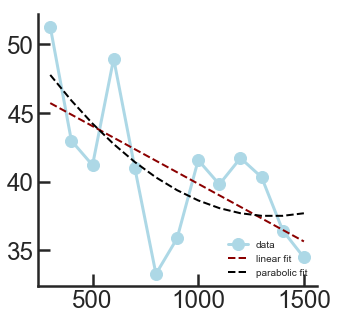

26
319.6786061342595 265.77738732776817
linear negative




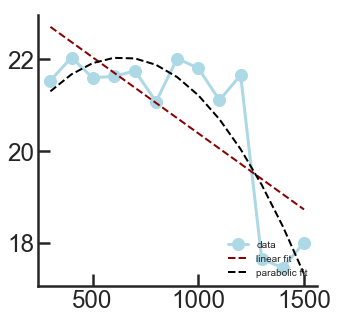

27
13.74610890935719 23.520530334560434
parabola negative




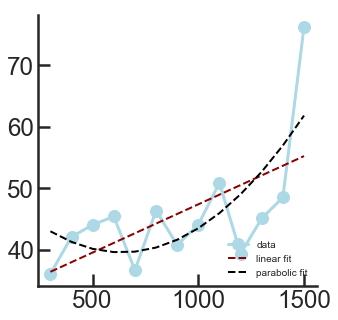

28
1614.3266201850533 1298.5150864557386
linear positive




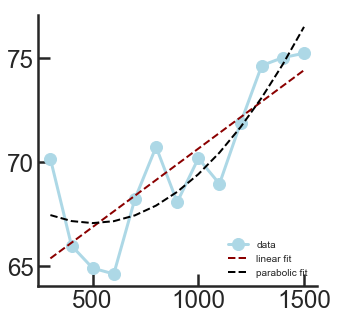

29
76.73484758957477 84.39367030443537
parabola positive




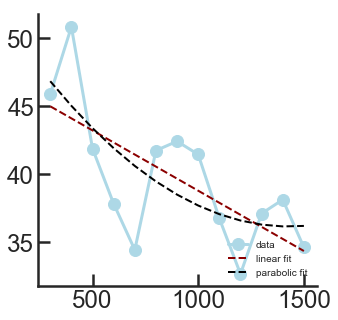

30
236.35183175050665 224.66137428509703
linear negative




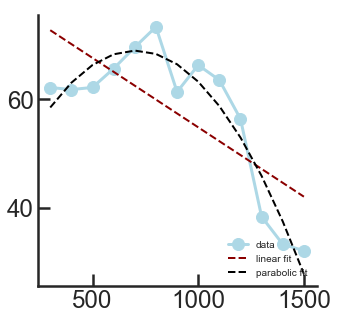

31
426.2468582875363 1551.3627642074264
parabola negative




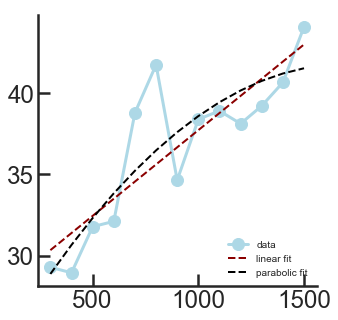

32
119.29083338184856 100.115509378474
linear positive




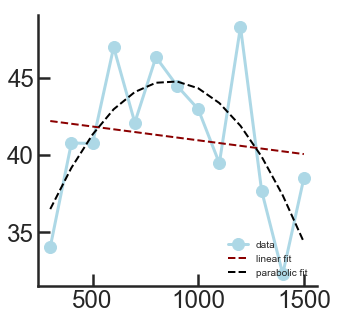

33
271.4889876232624 413.56646489337083
parabola negative




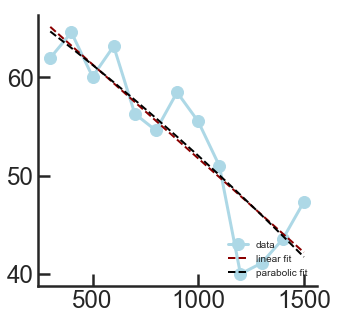

34
366.99124208269325 259.9775529935982
linear negative




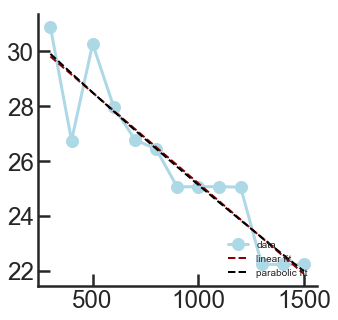

35
25.3543562813784 20.97878724481
linear negative




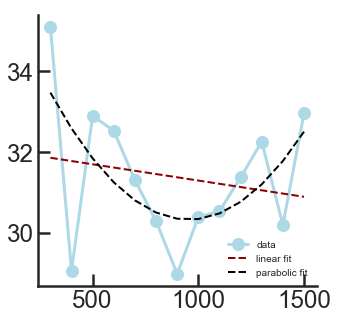

36
49.51640844135352 56.09266581374981
parabola positive




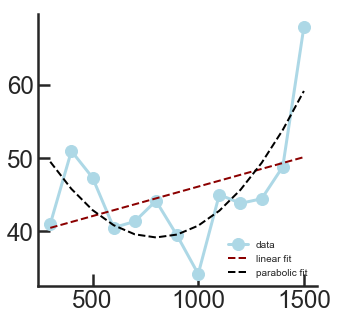

37
913.3663746174408 1065.2589182981455
parabola positive




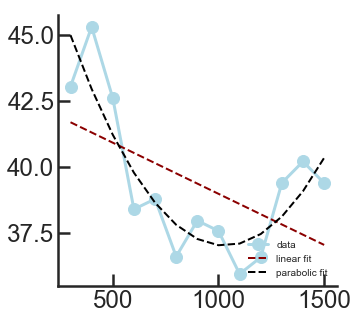

38
46.82774313511808 96.73654066566752
parabola positive




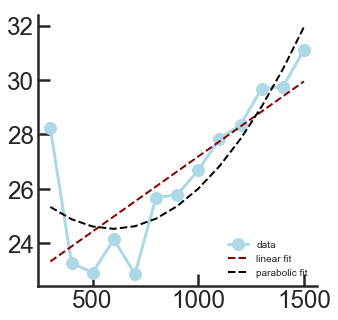

39
57.22310983645285 64.21585420196332
parabola positive




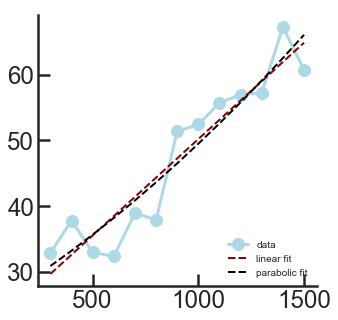

40
396.2966421849499 295.65623126737484
linear positive




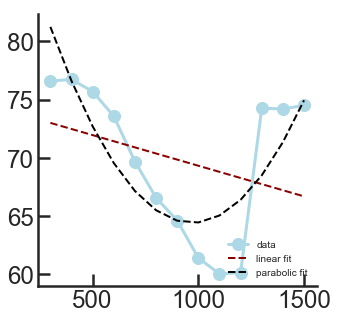

41
302.59880896800547 641.9756367329697
parabola positive




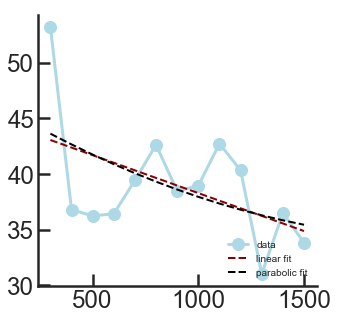

42
654.4745898030251 418.28452668999023
linear negative




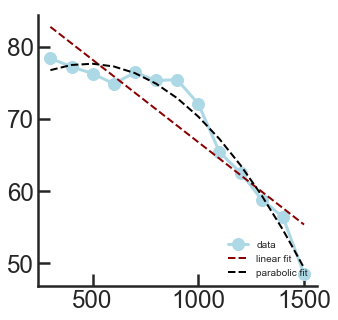

43
51.95472601566145 264.33114308848195
parabola negative




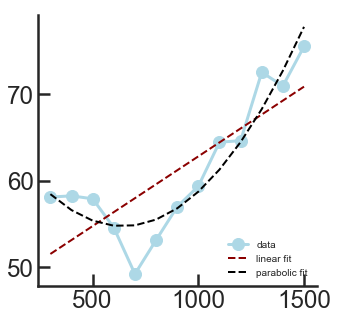

44
134.5093175881607 402.93005650844395
parabola positive




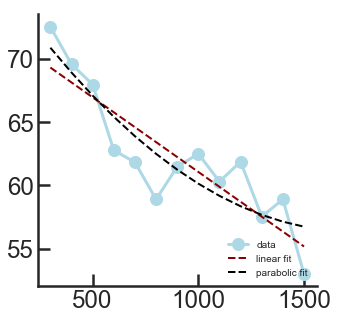

45
139.28565986574594 105.65958516025677
linear negative




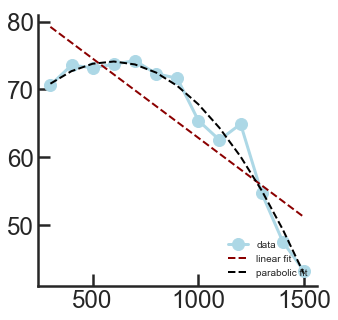

46
55.41077857569147 514.5025837153505
parabola negative




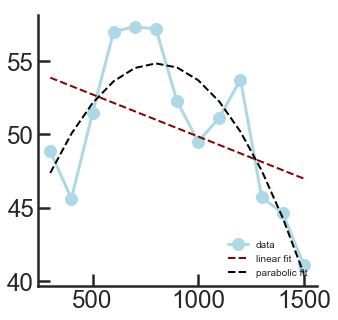

47
139.83391084357288 392.6828558039691
parabola negative




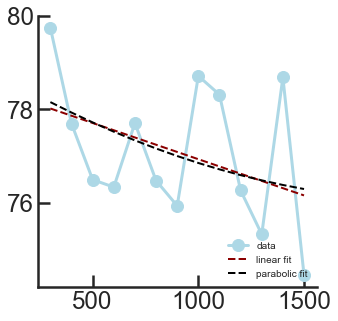

48
52.67974278627301 35.49397655306955
linear negative




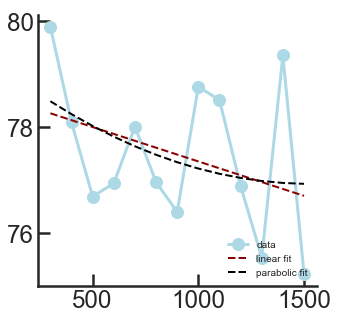

49
46.4028841140762 32.358848005895226
linear negative




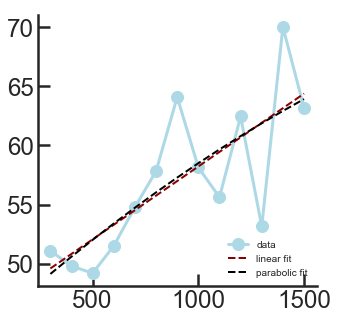

50
340.4733991739722 297.3974231174824
linear positive




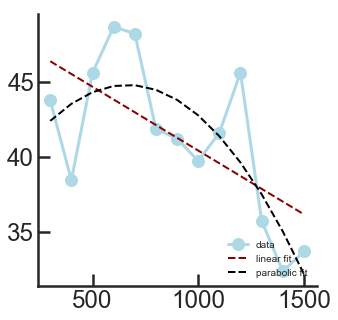

51
205.87114247645206 281.3122216510394
parabola negative




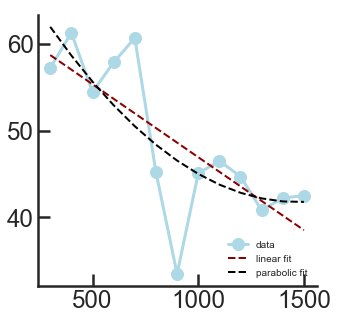

52
571.0488460698236 495.69481686816874
linear negative




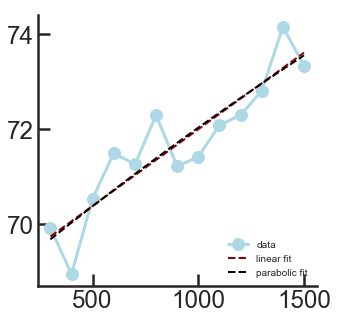

53
7.518378391615099 6.317259227007746
linear positive




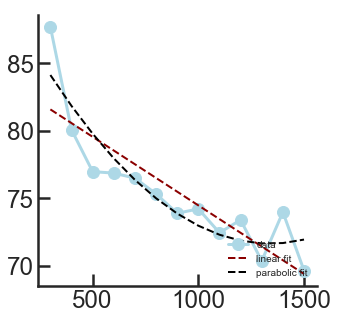

54
114.05439707094627 115.64670530167189
parabola positive




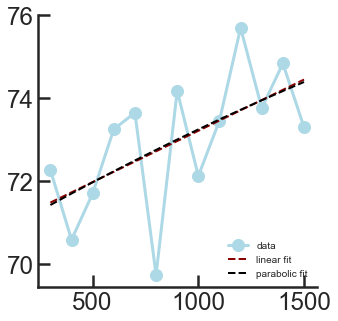

55
37.09500833989305 28.70660647431486
linear positive




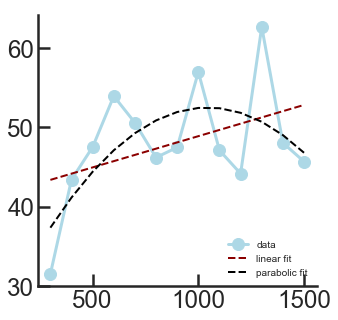

56
655.7009563042268 834.4866297570786
parabola negative




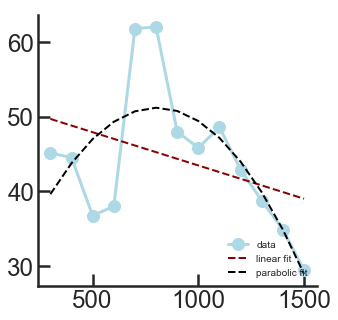

57
830.0558394965802 1279.1259953852343
parabola negative




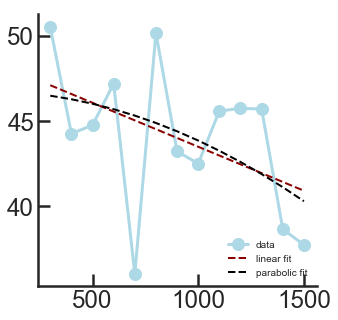

58
327.5758259160513 250.6628453531945
linear negative




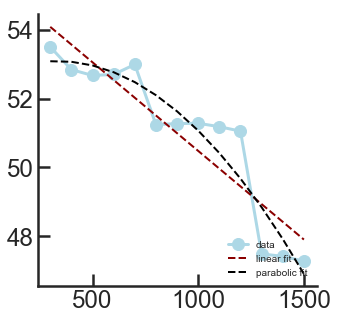

59
9.746226704526807 14.452025604965334
parabola negative




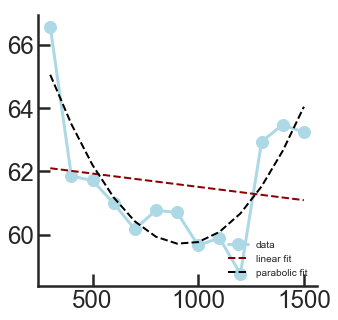

60
29.748009090312884 80.93923983866972
parabola positive




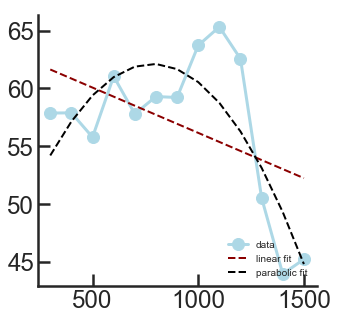

61
314.0657854841505 598.8744862041477
parabola negative




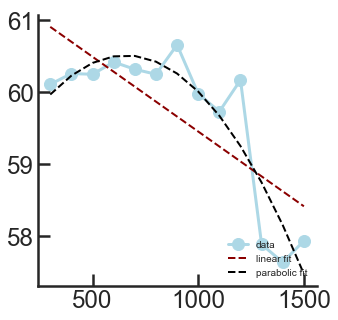

62
4.096807653284783 8.67971065307192
parabola negative




In [314]:
parab_n_300=[]
linear_n_300=[]

total=len(heatmaps_pfc_300)

for i in range(total):
    n1 = heatmaps_pfc_300[i]
    data_ = n1[16, 8:21]
    x_data = np.arange(300, 1600, 100)
    y_data=data_

    plt.figure(figsize=(5, 5))      
    #############################
    plt.plot(x_data, y_data, '-', color='lightblue', marker='o', label='data')
    #############################    
    ###############################
    poptl, pcov = curve_fit(line, x_data, y_data, method='dogbox', maxfev=1000 )
    y_fit = [poptl[0]*x + poptl[1] for x in x_data]
    plt.plot(x_data, y_fit, '--', color='darkred', linewidth=2, label='linear fit')

    popt, pcov = curve_fit(parabola, x_data, y_data, method='dogbox',  maxfev=1000 )
    y_fit = [popt[0]*x**2 + popt[1]*x + popt[2] for x in x_data]
    plt.plot(x_data, y_fit, 'k--', linewidth=2, label='parabolic fit')
    ##############################
    ##############################
    plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
    plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
    plt.gca().get_xaxis().tick_bottom()                                                                                         
    plt.gca().get_yaxis().tick_left()
    plt.gca().tick_params(direction='in') #direction
    plt.legend(loc=4, frameon=False, prop={'size': 10})

    plt.show()

    parab_ssq = Cross_validate_model(x_data, y_data, parabola, fit_parabola)
    line_ssq = Cross_validate_model(x_data, y_data, line, fit_line)
    print(i)
    print(parab_ssq, line_ssq)
    if parab_ssq<line_ssq:
        if popt[0]>0:
            print('parabola positive')
            #parab_p.append(i)
        else:
            print('parabola negative')
            parab_n_300.append(i)
    else:
        linear.append(i)
        if poptl[0]>0:
            print('linear positive')
            #linear_p.append(i)
        else:
            print('linear negative')
            linear_n_300.append(i)
                  
    #
    print('')
    print('')
    
######
######


In [318]:
## percentage of each
print(int(len(parab_n_300)/total*100), int(len(linear_n_300)/total*100))

26 30


In [325]:
parb_neg_neurons_300 = pfc_300.neuron.unique()[parab_n_300]
parb_neg_neurons_300

array([189168701, 189173101, 189174201, 189175801, 189176901,   1891783,
       189179702, 189181001,   1891857, 189188901, 189189601, 189192001,
       189195301, 189196301, 189209101, 189210001, 189210901], dtype=int64)

In [326]:
linear_neg_neurons_300 = pfc_300.neuron.unique()[linear_n_300]
linear_neg_neurons_300

array([  1367701,   1369901,   1370202,   1372003,   1372402, 189169502,
       189171602, 189173801, 189175201, 189177701,   1891793, 189181502,
         1891819, 189184601, 189187301, 189191601, 189191602, 189192201,
       189196401], dtype=int64)

In [ ]:
### dlpfc 900

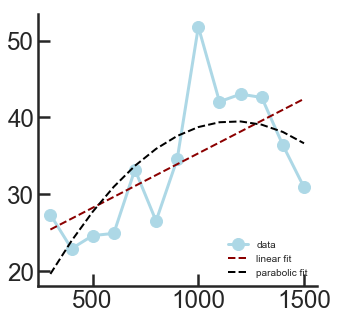

0
898.2100222440358 816.6710610299634
linear positive




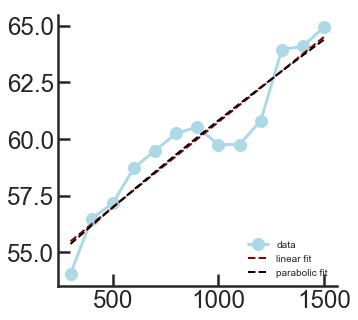

1
23.677690487479783 17.588031630751363
linear positive




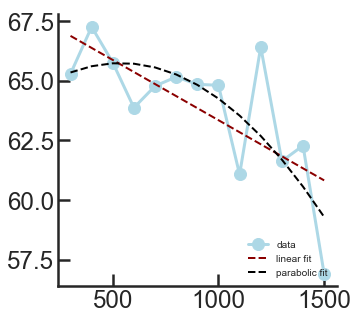

2
68.35023532425436 70.00668868710814
parabola negative




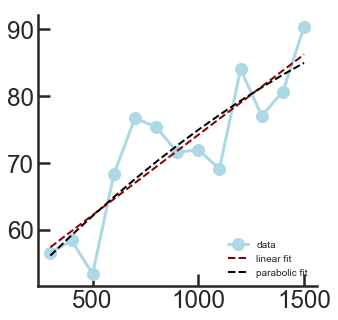

3
579.161268096007 476.9028842053596
linear positive




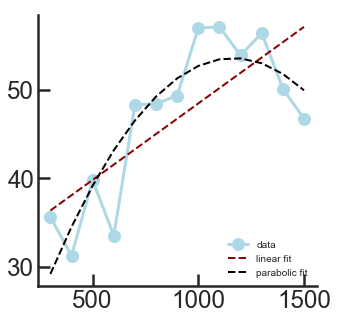

4
446.06007531509545 623.9959471480015
parabola negative




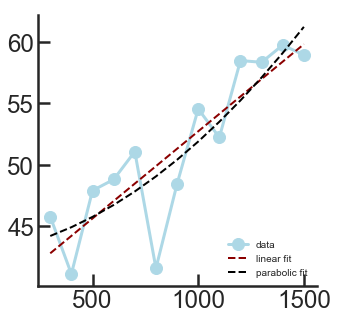

5
202.9588981834073 170.33441677424887
linear positive




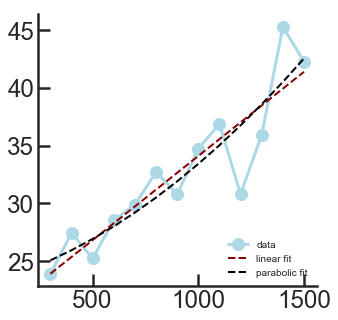

6
132.32920917504273 127.3794398851955
linear positive




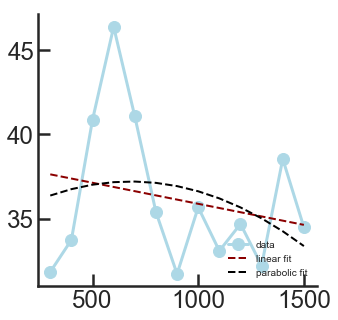

7
374.30593092977335 315.1111458146709
linear negative




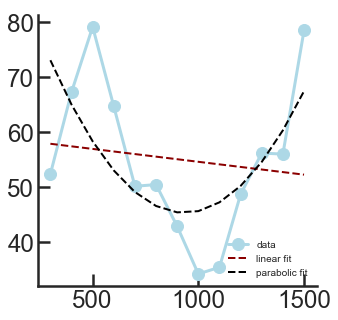

8
3623.7107152711205 3551.4579466617315
linear negative




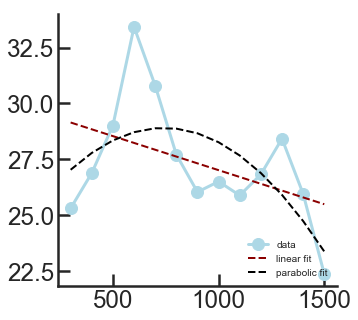

9
87.32460318292918 109.94039596467591
parabola negative




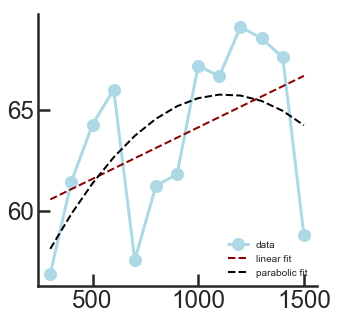

10
297.18657132648235 265.20923996674446
linear positive




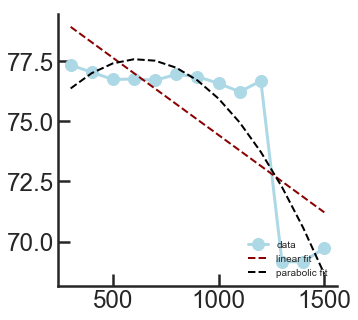

11
43.74360336230294 75.1995617685896
parabola negative




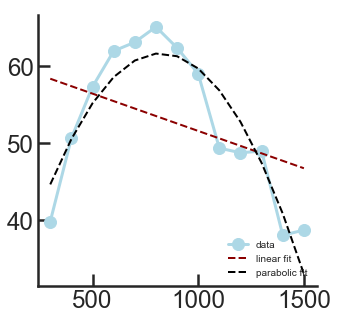

12
404.03049852502795 1483.4102574155233
parabola negative




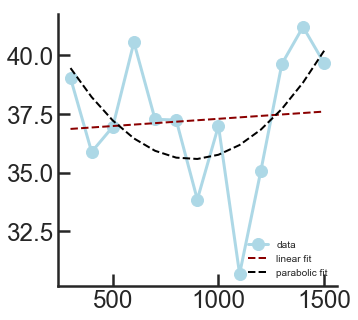

13
109.79960871842735 139.08875866080493
parabola positive




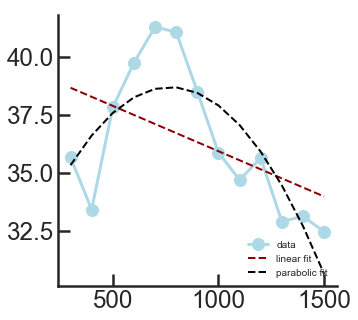

14
72.75868100895262 124.85862055308658
parabola negative




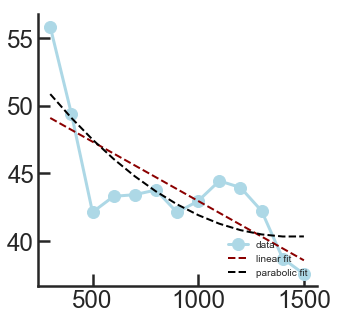

15
231.22751574367066 175.14389496720793
linear negative




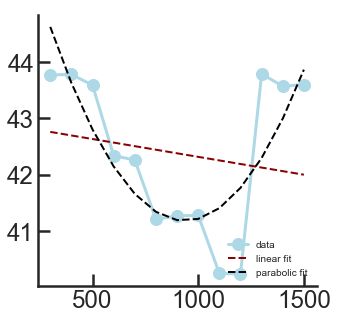

16
13.772946728385088 32.25564414339134
parabola positive




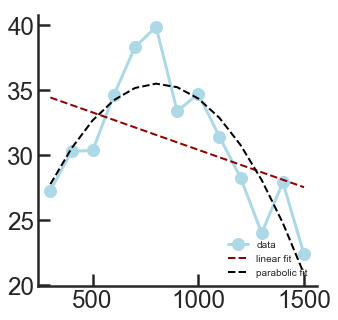

17
118.96285703281657 377.3950389197475
parabola negative




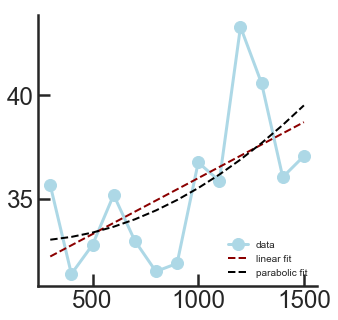

18
175.6293936047001 137.5016754834713
linear positive




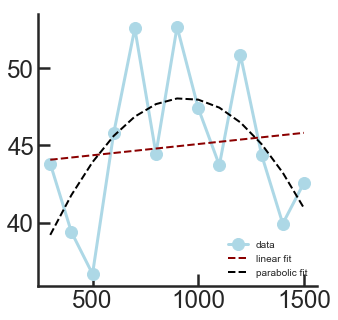

19
345.56123536363884 394.4117430964248
parabola negative




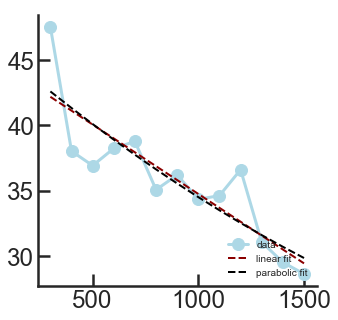

20
179.9571191203711 115.26736927747717
linear negative




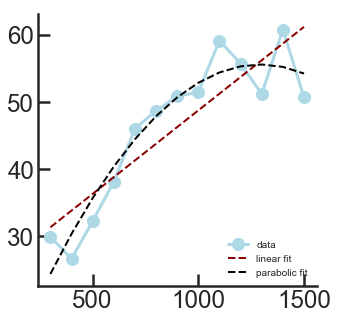

21
360.1108800043936 536.3523438476698
parabola negative




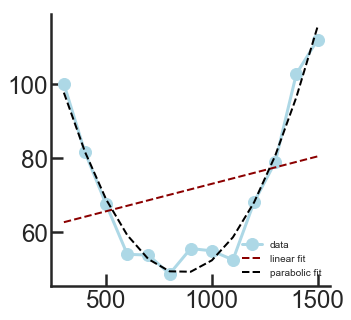

22
316.4167222376619 8361.150694326
parabola positive




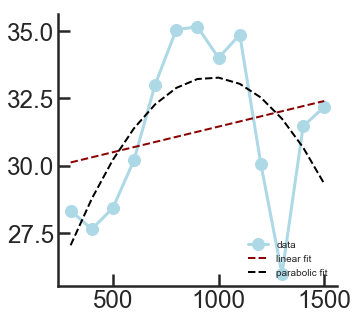

23
126.3722323940928 144.13118887336734
parabola negative




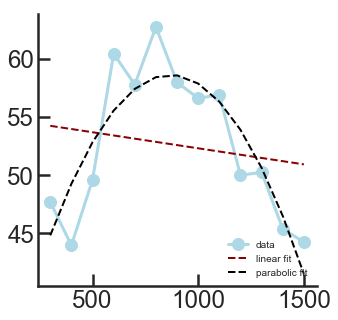

24
222.38856585970933 709.6229038617018
parabola negative




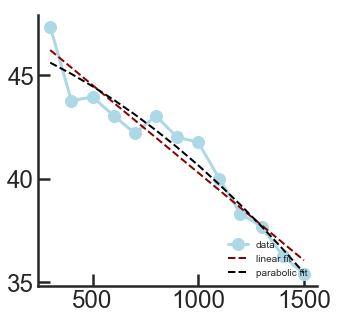

25
21.67024807701556 14.726341584047752
linear negative




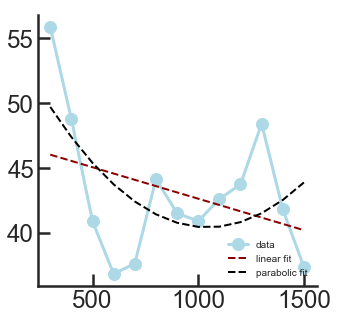

26
570.4196712744614 459.9631197995642
linear negative




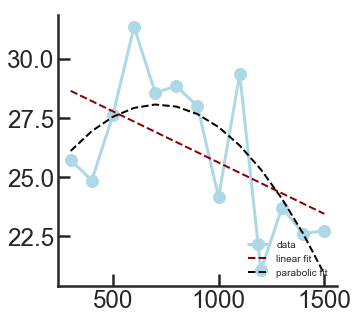

27
90.75760944642565 116.06911539444327
parabola negative




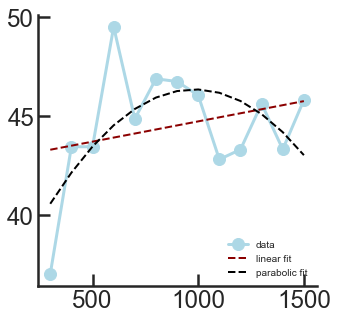

28
150.9919986067965 150.09544824902008
linear positive




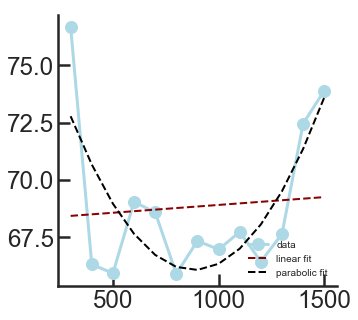

29
137.59971028561702 237.83318808967093
parabola positive




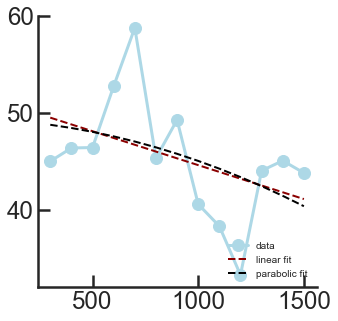

30
612.6147951390584 509.6253968379919
linear negative




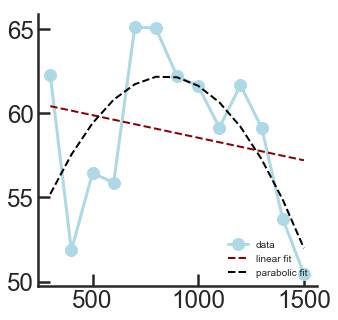

31
377.20960986355465 391.5820559358559
parabola negative




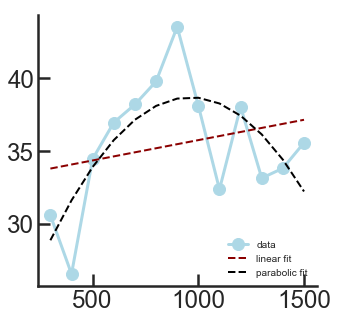

32
215.1957016122358 296.5778963303222
parabola negative




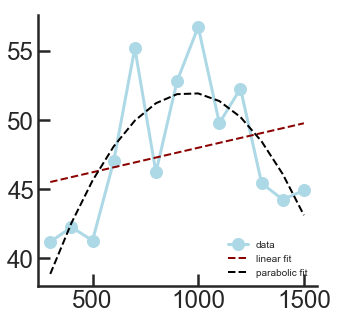

33
202.92891485466538 425.6372296241236
parabola negative




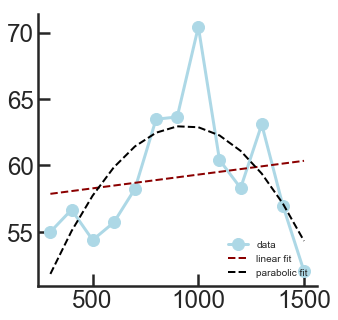

34
242.77483037508628 412.1125284565811
parabola negative




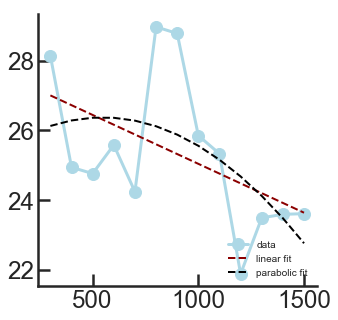

35
69.51853865962404 53.87711054542428
linear negative




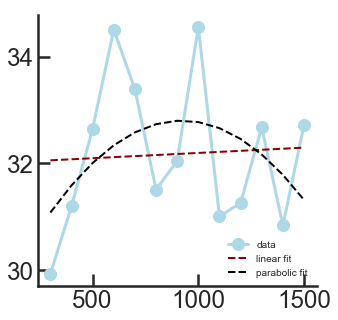

36
37.56554269170327 33.861953748067556
linear positive




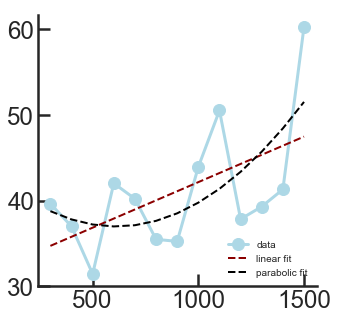

37
787.7774707940268 709.41090304419
linear positive




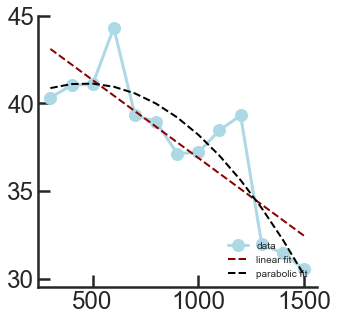

38
56.83451385625154 87.97771612594106
parabola negative




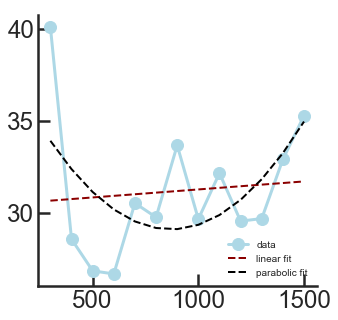

39
283.298952798901 273.8158626801778
linear positive




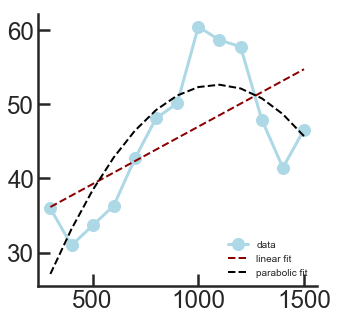

40
757.2366906099031 978.2088129568426
parabola negative




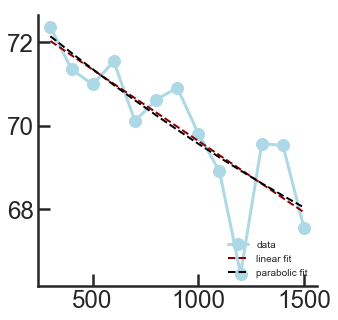

41
16.83060488889872 15.118190251629896
linear negative




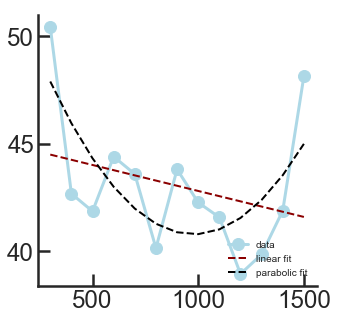

42
146.6342624272614 195.3794052472585
parabola positive




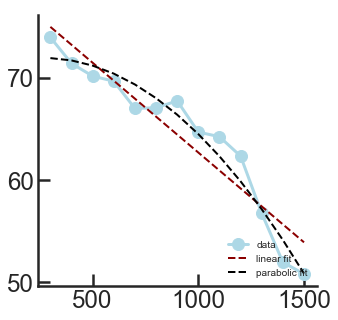

43
53.950762138517135 96.83499161956138
parabola negative




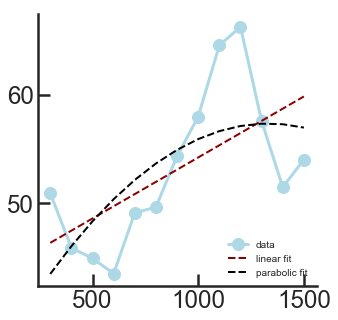

44
661.179765553783 522.5503841937384
linear positive




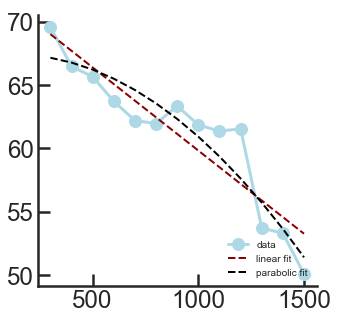

45
84.65700966513164 83.70420272261015
linear negative




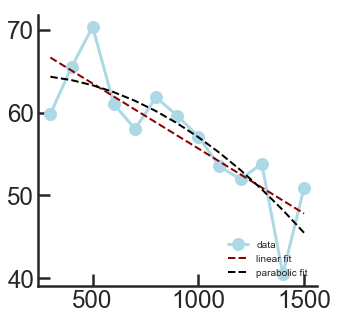

46
443.08998259944553 341.64365275145326
linear negative




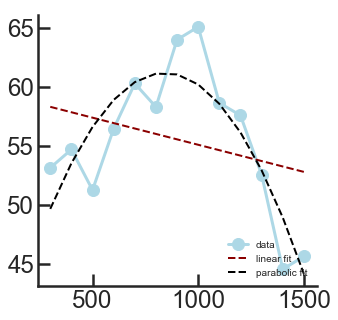

47
211.12627581563788 604.8018019463194
parabola negative




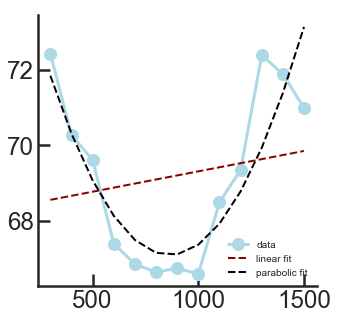

48
34.404797766370685 86.92923940269749
parabola positive




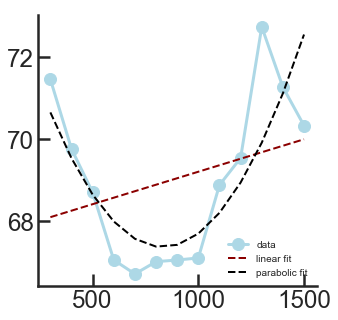

49
39.82480914643155 64.73258394922894
parabola positive




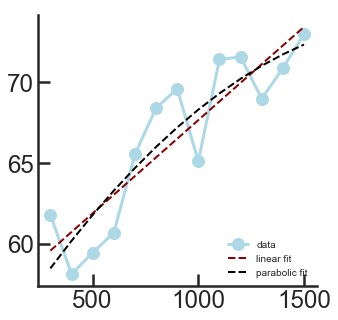

50
122.42008772765783 90.29094812991781
linear positive




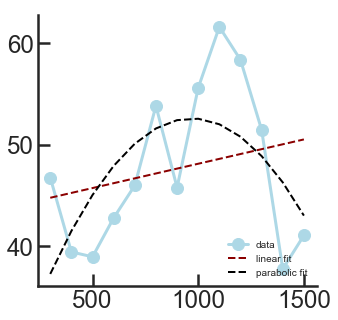

51
959.9759132600319 1007.5318067034714
parabola negative




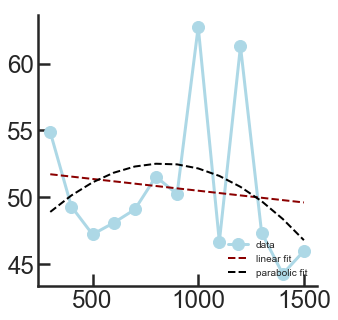

52
605.7826982985495 512.9971056712407
linear negative




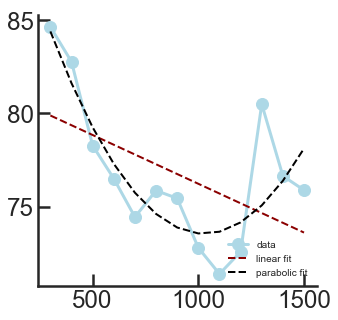

53
88.26944005068644 199.09991644509586
parabola positive




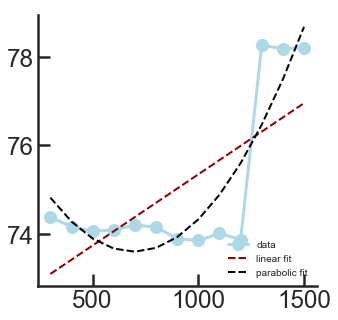

54
13.904265047862943 30.4489904480002
parabola positive




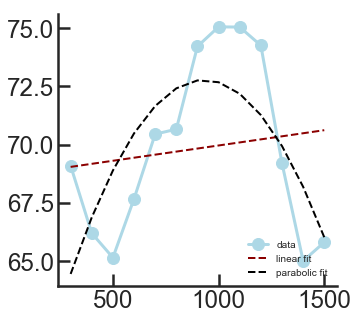

55
185.6877741779393 245.3437939646642
parabola negative




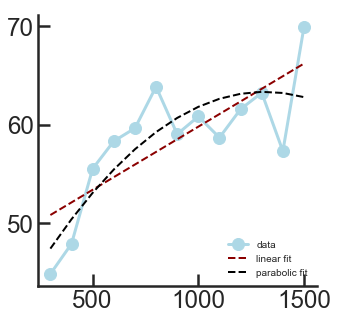

56
408.51654043574615 317.4361100378422
linear positive




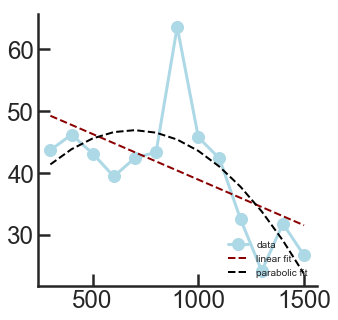

57
871.323000293179 1050.0214381014132
parabola negative




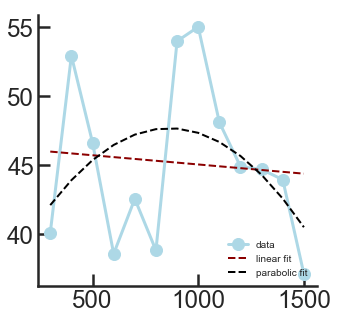

58
599.2913862099826 595.2526574691537
linear negative




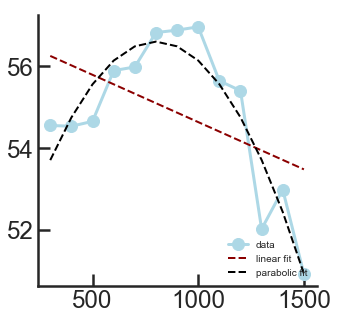

59
11.298933907635789 48.792625416505864
parabola negative




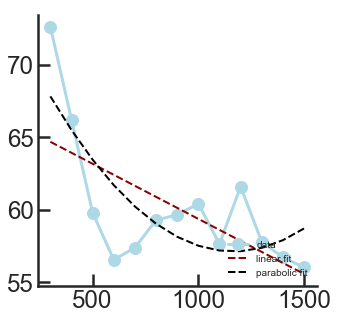

60
241.18244504013344 236.6487439585314
linear negative




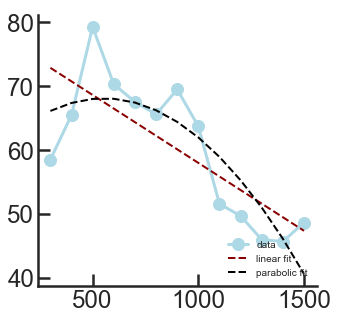

61
918.2870449546823 903.4114590309657
linear negative




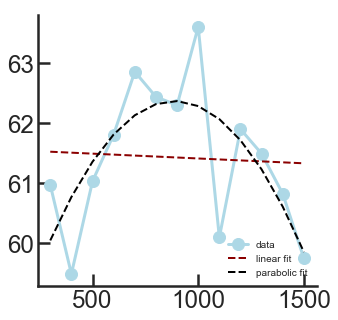

62
15.95887441032602 25.65762176611453
parabola negative




In [308]:
parab_n_900=[]
linear_n_900=[]

total=len(heatmaps_pfc_900)

for i in range(total):
    n1 = heatmaps_pfc_900[i]
    data_ = n1[16, 8:21]
    x_data = np.arange(300, 1600, 100)
    y_data=data_

    plt.figure(figsize=(5, 5))      
    #############################
    plt.plot(x_data, y_data, '-', color='lightblue', marker='o', label='data')
    #############################    
    ###############################
    poptl, pcov = curve_fit(line, x_data, y_data, method='dogbox', maxfev=1000 )
    y_fit = [poptl[0]*x + poptl[1] for x in x_data]
    plt.plot(x_data, y_fit, '--', color='darkred', linewidth=2, label='linear fit')

    popt, pcov = curve_fit(parabola, x_data, y_data, method='dogbox',  maxfev=1000 )
    y_fit = [popt[0]*x**2 + popt[1]*x + popt[2] for x in x_data]
    plt.plot(x_data, y_fit, 'k--', linewidth=2, label='parabolic fit')
    ##############################
    ##############################
    plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
    plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
    plt.gca().get_xaxis().tick_bottom()                                                                                         
    plt.gca().get_yaxis().tick_left()
    plt.gca().tick_params(direction='in') #direction
    plt.legend(loc=4, frameon=False, prop={'size': 10})

    plt.show()

    parab_ssq = Cross_validate_model(x_data, y_data, parabola, fit_parabola)
    line_ssq = Cross_validate_model(x_data, y_data, line, fit_line)
    print(i)
    print(parab_ssq, line_ssq)
    if parab_ssq<line_ssq:
        if popt[0]>0:
            print('parabola positive')
            #parab_p.append(i)
        else:
            print('parabola negative')
            parab_n_900.append(i)
    else:
        linear.append(i)
        if poptl[0]>0:
            print('linear positive')
            #linear_p.append(i)
        else:
            print('linear negative')
            linear_n_900.append(i)
                  
    #
    print('')
    print('')
    
######
######


In [309]:
## percentage of each
print(int(len(parab_n_900)/total*100), int(len(linear_n_900)/total*100))

39 23


In [323]:
parb_neg_neurons_900 = pfc_900.neuron.unique()[parab_n_900]
parb_neg_neurons_900

array([  1367903,   1369901,   1372003,   1372402, 189168701, 189171003,
       189173101, 189174201, 189175801, 189176501, 189176901,   1891783,
       189179702, 189180001, 189181001, 189181502, 189182901, 189183402,
         1891857, 189189601, 189192001, 189194301, 189196301, 189209101,
       189210901], dtype=int64)

In [324]:
linear_neg_neurons_900 = pfc_900.neuron.unique()[linear_n_900]
linear_neg_neurons_900

array([  1371202,   1371901, 189171602, 189175201, 189177402, 189177701,
         1891793,   1891819,   1891841, 189187301, 189188901, 189192201,
       189196401, 189209503, 189210001], dtype=int64)

In [332]:
subset_heatmaps_pfc_900=[]

for n_neuron,neuron_ in enumerate(parb_neg_neurons_900):
    print(n_neuron, neuron_)
    ## get the neuron
    dfN = pfc_900.loc[pfc_900['neuron']==neuron_]
    ## column of times centered to stim onset
    dfN['times_centered'] = dfN['times'] - dfN['fixationtime']

    #cross-decoding for 1 neuron
    ### empty matrix to append the cross temporal decoding
    all_times = np.arange(-500,2100, 100)
    train_test = np.empty( (len(all_times), len(all_times) ) )
    train_test[:] = np.nan

    ### times I am interested in (no need to get more times)
    dfN = dfN.loc[(dfN['times_centered']>=-500) & (dfN['times_centered']<=2000) ]
    list_times = dfn.times_centered.unique()
    list_times_sorted =np.sort(list_times)
    list_times_sorted

    for training_time in list_times_sorted:
        #print(training_time)
        dfn_train = dfN.loc[(dfN['times_centered']==training_time), ['firing', 'target_angle']]         
        dfn_train = dfn_train.loc[dfn_train.iloc[:,0]<9999] ###Take off nans
        paralel_train = [dfn_train for i in range(len(list_times_sorted))]

        paralel_test = []
        for times_testing in list_times_sorted:
            dfn_test =dfN.loc[(dfN['times_centered']==times_testing), ['firing', 'target_angle']]
            dfn_test = dfn_test.loc[dfn_test.iloc[:,0]<9999] ###Take off nans
            paralel_test.append(dfn_test)

        cross_temp = Parallel(n_jobs = numcores)(delayed(decoder)(training, testing)  for training, testing in zip(paralel_train, paralel_test) )   #### reconstruction standard (paralel)

        idx_append_row = np.where(training_time == all_times )[0][0]
        idx_append_col1 = np.where(list_times_sorted[0] == all_times)[0][0]
        idx_append_col2 = np.where(list_times_sorted[-1] == all_times)[0][0]
        train_test[idx_append_row, idx_append_col1:idx_append_col2+1] = cross_temp
    ##
    subset_heatmaps_pfc_900.append(train_test)

0 1367903


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


1 1369901
2 1372003
3 1372402
4 189168701
5 189171003
6 189173101
7 189174201
8 189175801
9 189176501
10 189176901
11 1891783
12 189179702
13 189180001
14 189181001
15 189181502
16 189182901
17 189183402
18 1891857
19 189189601
20 189192001
21 189194301
22 189196301
23 189209101
24 189210901


In [333]:
subset_heatmaps_pfc_900_L=[]

for n_neuron,neuron_ in enumerate(linear_neg_neurons_900):
    print(n_neuron, neuron_)
    ## get the neuron
    dfN = pfc_900.loc[pfc_900['neuron']==neuron_]
    ## column of times centered to stim onset
    dfN['times_centered'] = dfN['times'] - dfN['fixationtime']

    #cross-decoding for 1 neuron
    ### empty matrix to append the cross temporal decoding
    all_times = np.arange(-500,2100, 100)
    train_test = np.empty( (len(all_times), len(all_times) ) )
    train_test[:] = np.nan

    ### times I am interested in (no need to get more times)
    dfN = dfN.loc[(dfN['times_centered']>=-500) & (dfN['times_centered']<=2000) ]
    list_times = dfn.times_centered.unique()
    list_times_sorted =np.sort(list_times)
    list_times_sorted

    for training_time in list_times_sorted:
        #print(training_time)
        dfn_train = dfN.loc[(dfN['times_centered']==training_time), ['firing', 'target_angle']]         
        dfn_train = dfn_train.loc[dfn_train.iloc[:,0]<9999] ###Take off nans
        paralel_train = [dfn_train for i in range(len(list_times_sorted))]

        paralel_test = []
        for times_testing in list_times_sorted:
            dfn_test =dfN.loc[(dfN['times_centered']==times_testing), ['firing', 'target_angle']]
            dfn_test = dfn_test.loc[dfn_test.iloc[:,0]<9999] ###Take off nans
            paralel_test.append(dfn_test)

        cross_temp = Parallel(n_jobs = numcores)(delayed(decoder)(training, testing)  for training, testing in zip(paralel_train, paralel_test) )   #### reconstruction standard (paralel)

        idx_append_row = np.where(training_time == all_times )[0][0]
        idx_append_col1 = np.where(list_times_sorted[0] == all_times)[0][0]
        idx_append_col2 = np.where(list_times_sorted[-1] == all_times)[0][0]
        train_test[idx_append_row, idx_append_col1:idx_append_col2+1] = cross_temp
    ##
    subset_heatmaps_pfc_900_L.append(train_test)

0 1371202


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


1 1371901
2 189171602
3 189175201
4 189177402
5 189177701
6 1891793
7 1891819
8 1891841
9 189187301
10 189188901
11 189192201
12 189196401
13 189209503
14 189210001


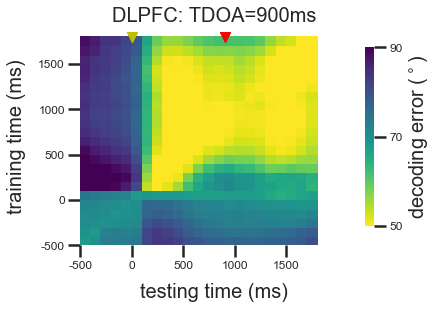

In [295]:
H = [pd.DataFrame(heatmaps_pfc_900[x]) for x in range(len(heatmaps_pfc_900))]
H_mean = pd.concat(H).groupby(level=0).mean()
heatmap(H_mean, 'DLPFC: TDOA=' +str(900)+'ms', dist_time=800)

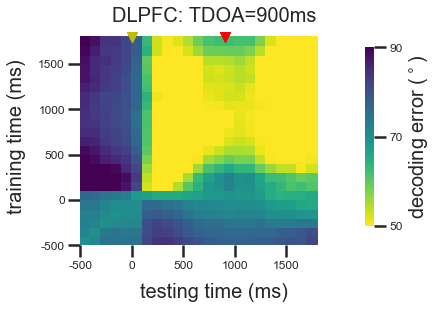

In [296]:
##evidentemente, es circular!
H = [pd.DataFrame(subset_heatmaps_pfc_900[x]) for x in range(len(subset_heatmaps_pfc_900))]
H_mean = pd.concat(H).groupby(level=0).mean()
heatmap(H_mean, 'DLPFC: TDOA=' +str(900)+'ms', dist_time=800)

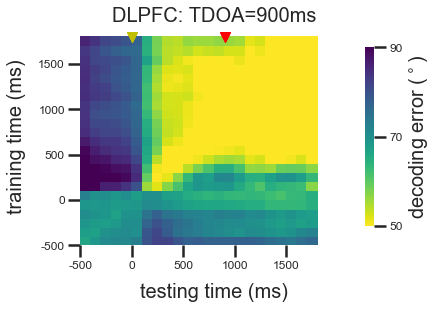

In [334]:
##evidentemente, es circular!
H = [pd.DataFrame(subset_heatmaps_pfc_900_L[x]) for x in range(len(subset_heatmaps_pfc_900_L))]
H_mean = pd.concat(H).groupby(level=0).mean()
heatmap(H_mean, 'DLPFC: TDOA=' +str(900)+'ms', dist_time=800)

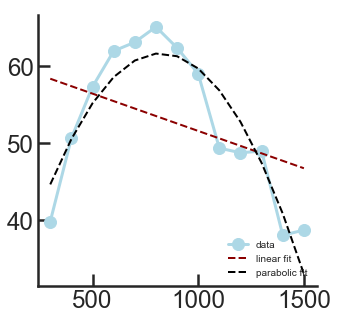

62
404.03049852502795 1483.4102574155233
parabola


In [275]:
###neuron 12
n1 = heatmaps_pfc_900[12]
data_ = n1[16, 8:21]
x_data = np.arange(300, 1600, 100)
y_data=data_

plt.figure(figsize=(5, 5))      
#############################
plt.plot(x_data, y_data, '-', color='lightblue', marker='o', label='data')
#############################    
###############################
popt, pcov = curve_fit(line, x_data, y_data, method='dogbox', maxfev=1000 )
y_fit = [popt[0]*x + popt[1] for x in x_data]
plt.plot(x_data, y_fit, '--', color='darkred', linewidth=2, label='linear fit')

popt, pcov = curve_fit(parabola, x_data, y_data, method='dogbox',  maxfev=1000 )
y_fit = [popt[0]*x**2 + popt[1]*x + popt[2] for x in x_data]
plt.plot(x_data, y_fit, 'k--', linewidth=2, label='parabolic fit')


plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
plt.gca().get_xaxis().tick_bottom()                                                                                         
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params(direction='in') #direction
plt.legend(loc=4, frameon=False, prop={'size': 10})

plt.show()

parab_ssq = Cross_validate_model(x_data, y_data, parabola, fit_parabola)
line_ssq = Cross_validate_model(x_data, y_data, line, fit_line)
print(i)
print(parab_ssq, line_ssq)
if parab_ssq<line_ssq:
    print('parabola')
else:
    print('linear')

In [276]:
popt

array([-6.22327668e-05,  1.02353046e-01,  1.95456946e+01])

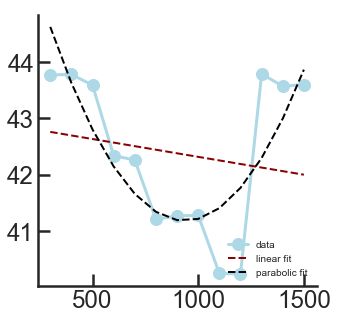

62
13.772946728385088 32.25564414339134
parabola


In [277]:
###neuron 16
n1 = heatmaps_pfc_900[16]
data_ = n1[16, 8:21]
x_data = np.arange(300, 1600, 100)
y_data=data_

plt.figure(figsize=(5, 5))      
#############################
plt.plot(x_data, y_data, '-', color='lightblue', marker='o', label='data')
#############################    
###############################
popt, pcov = curve_fit(line, x_data, y_data, method='dogbox', maxfev=1000 )
y_fit = [popt[0]*x + popt[1] for x in x_data]
plt.plot(x_data, y_fit, '--', color='darkred', linewidth=2, label='linear fit')

popt, pcov = curve_fit(parabola, x_data, y_data, method='dogbox',  maxfev=1000 )
y_fit = [popt[0]*x**2 + popt[1]*x + popt[2] for x in x_data]
plt.plot(x_data, y_fit, 'k--', linewidth=2, label='parabolic fit')


plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
plt.gca().get_xaxis().tick_bottom()                                                                                         
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params(direction='in') #direction
plt.legend(loc=4, frameon=False, prop={'size': 10})

plt.show()

parab_ssq = Cross_validate_model(x_data, y_data, parabola, fit_parabola)
line_ssq = Cross_validate_model(x_data, y_data, line, fit_line)
print(i)
print(parab_ssq, line_ssq)
if parab_ssq<line_ssq:
    print('parabola')
else:
    print('linear')

In [278]:
popt

array([ 8.47152847e-06, -1.58817183e-02,  4.86263636e+01])

In [ ]:
### stim specific (linear neg vs parab)

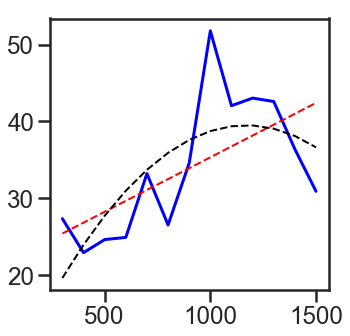

In [261]:

plt.figure(figsize=(5, 5))      
#############################
x_data = np.arange(300, 1600, 100)
y_data=data_
plt.plot(x_data, y_data, 'b-', label='real')
#############################    
###############################
popt, pcov = curve_fit(line, x_data, y_data, method='dogbox', maxfev=1000 )
y_fit = [popt[0]*x + popt[1] for x in x_data]
plt.plot(x_data, y_fit, 'r--', linewidth=2, label='linear fit')

popt, pcov = curve_fit(parabola, x_data, y_data, method='dogbox',  maxfev=1000 )
y_fit = [popt[0]*x**2 + popt[1]*x + popt[2] for x in x_data]
plt.plot(x_data, y_fit, 'k--', linewidth=2, label='parabolic fit')

plt.show()

In [250]:
np.arange(300, 1600, 100)

array([ 300,  400,  500,  600,  700,  800,  900, 1000, 1100, 1200, 1300,
       1400, 1500])

array([27.33, 22.9 , 24.6 , 24.89, 33.2 , 26.51, 34.56, 51.79, 42.04,
       43.03, 42.59, 36.38, 30.89])

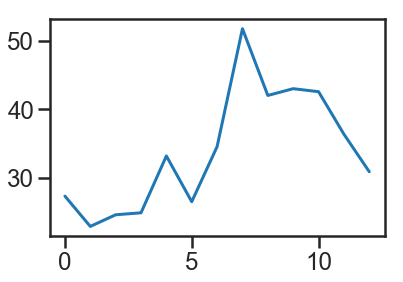

In [248]:
n1 = heatmaps_pfc_900[0]
plt.plot(n1[16, 8:21])
data_ = n1[16, 8:21]
data_

([<matplotlib.axis.XTick at 0x179c1f79390>,
 <a list of 6 Text xticklabel objects>)

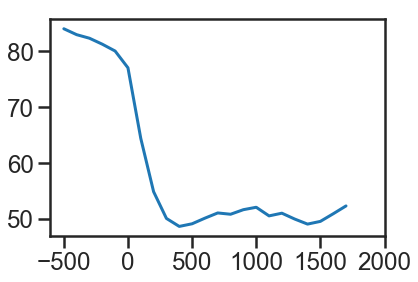

In [229]:
plt.plot(np.arange(-500,2100, 100), np.mean(apps, axis=0))
plt.xticks(np.arange(-500,2100, 500))

In [171]:
dfn_train

firing  target_angle
4772  5.500830e-02           225
4795  5.298962e-02           225
4814  2.080248e-04            45
4840 -1.208642e-18           360
4856  6.336929e-19           225
...            ...           ...
7168  5.024093e-02           270
7189  2.339006e-02           270
7210  1.496089e-02           180
7231  3.682093e-02           225
7252  1.003298e-02           360

[119 rows x 2 columns]

In [173]:
dfn_test

firing  target_angle
4787  2.728294e-02           225
4829 -3.203190e-18            45
4871  2.080248e-04           225
4892  3.332432e-18           270
5039           NaN           225
5123  1.077019e-20           270
5186 -6.073699e-19           225
5270 -9.860449e-19            90
5312 -5.226685e-19            90
5333           NaN           135
5438  8.332946e-03           180
5480  2.515888e-02           180
5543 -1.122364e-19           360
5585  1.840539e-18           270
5669  9.968223e-03           225
5690 -9.896290e-19           135
5774  3.140524e-18           225
5795  3.434188e-06           270
5858 -9.663789e-19           315
5879  2.108779e-18           270
5963 -7.043255e-20           360
5984  6.683348e-19            45
6110           NaN           270
6278  3.297984e-05           225
6341           NaN           180
6404  2.524540e-20            45
6425 -3.082472e-18            90
6446 -7.686612e-19           315
6488  9.911463e-09           225
6551  7.107337e-19           360
6635           NaN           225
6656           NaN           270
6761  2.484112e-03           225
6782  2.163615e-18           360
6845  7.531753e-19           270
6866  1.021099e-02           225
6929  1.500343e-02           270
6950 -1.778599e-18           225
7034 -1.255219e-18           225
7076  8.856299e-19           270
7118  2.277515e-18           360

In [49]:
df1 = df.loc[(df['times']==500) & (df['neuron']==1367701), ['firing', 'target_angle', 'neuron']] ###tiene que ser centered!
df2 = df.loc[(df['times']==600) & (df['neuron']==1367701), ['firing', 'target_angle', 'neuron']] ###tiene que ser centered!
cross_decoding_spikes_angles_err_all(df1, df2)

[60.657331230582926]

In [ ]:
### cambiar la funcion para que sea en cada neurona (asi poder identificar subpoblaciones)
### buscar en internet como hacer eso? PCA???
### idea! tres fits diferentes! compararlos en cada neurona! :)


In [58]:
df1 = df.loc[(df['times']==500) & (df['neuron']==1367701), ['firing', 'target_angle']] ###tiene que ser centered!
df2 = df.loc[(df['times']==600) & (df['neuron']==1367701), ['firing', 'target_angle']] ###tiene que ser centered!
decoder_n(df1, df2)

60.66

In [63]:
df['times_centered'] = df['times'] - df['fixationtime']

In [64]:
df.loc[df['neuron']==1367701, ['firing', 'target_angle', 'times_centered']]

firing  target_angle  times_centered
0    -3.637979e-19           225            -300
1     1.382432e-17           225            -200
2     1.127773e-17           225            -100
3     2.691904e-03           225               0
4     1.751611e-02           225             100
...            ...           ...             ...
2242  1.003299e-02           315             800
2243  2.412903e-02           315             900
2244  1.087097e-02           315            1000
2245  3.434188e-06           315            1100
2246  1.247725e-02           315            1200

[2247 rows x 3 columns]

In [68]:
dfn = df.loc[df['neuron']==1367701]
dfn.loc[(dfn['times_centered']>-500) & (dfn['times_centered']<2000) ]
dfn.head()

Unnamed: 0        firing  times  trial  TDOA  TDconf  targetloc  distLoc  \
0           0 -3.637979e-19      0      2     0       3          7        0   
1           1  1.382432e-17    100      2     0       3          7        0   
2           2  1.127773e-17    200      2     0       3          7        0   
3           3  2.691904e-03    300      2     0       3          7        0   
4           4  1.751611e-02    400      2     0       3          7        0   

   fixationtime  failed  saccadeChoice monkey   neuron brain_region  rf_loc  \
0           300       1              7   Mojo  1367701        DLPFC     270   
1           300       1              7   Mojo  1367701        DLPFC     270   
2           300       1              7   Mojo  1367701        DLPFC     270   
3           300       1              7   Mojo  1367701        DLPFC     270   
4           300       1              7   Mojo  1367701        DLPFC     270   

   target_angle  times_centered  
0           225            -300  
1           225            -200  
2           225            -100  
3           225               0  
4           225             100

7

In [150]:
#cross-decoding for 1 neuron
all_times = np.arange(-500,2100, 100)
train_test = np.empty( (len(all_times), len(all_times) ) )
train_test[:] = np.nan


dfn = df.loc[df['neuron']==1367701]
dfn = dfn.loc[(dfn['times_centered']>=-500) & (dfn['times_centered']<=2000) ]
list_times = dfn.times_centered.unique()
list_times_sorted =np.sort(list_times)
list_times_sorted

for training_time in list_times_sorted:
    #print(training_time)
    dfn_train = dfn.loc[(dfn['times_centered']==training_time), ['firing', 'target_angle']]
    paralel_train = [dfn_train for i in range(len(list_times_sorted))]
    
    paralel_test = []
    for times_testing in list_times_sorted:
        dfn_test =dfn.loc[(dfn['times_centered']==times_testing), ['firing', 'target_angle']]
        paralel_test.append(dfn_test)

    cross_temp = Parallel(n_jobs = numcores)(delayed(decoder)(training, testing)  for training, testing in zip(paralel_train, paralel_test) )   #### reconstruction standard (paralel)

    idx_append_row = np.where(training_time == all_times )[0][0]
    idx_append_col1 = np.where(list_times_sorted[0] == all_times)[0][0]
    idx_append_col2 = np.where(list_times_sorted[-1] == all_times)[0][0]
    train_test[idx_append_row, idx_append_col1:idx_append_col2+1] = cross_temp


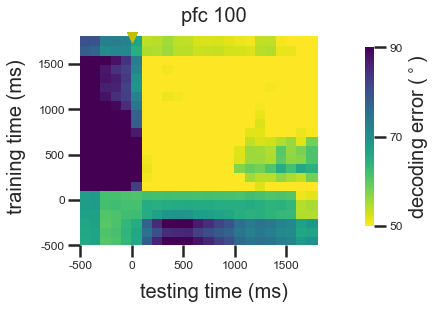

In [152]:
heatmap(train_test, 'pfc 100')

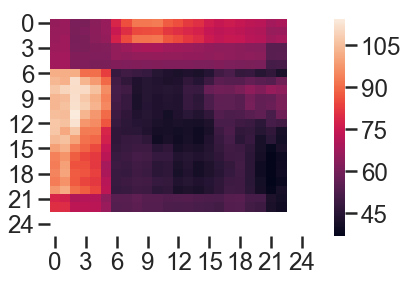

In [142]:
sns.heatmap(train_test)

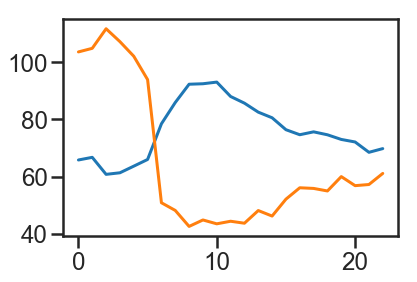

In [144]:
plt.plot(train_test[0, :])

plt.plot(train_test[9, :])

In [127]:
all_times = np.arange(-500,2100, 100)
train_test = np.empty( (len(all_times), len(all_times) ) )
train_test[:] = np.nan
np.shape(train_test)

(26, 26)

In [126]:
train_test

array([[65.81, 65.81, 65.81, 65.81, 65.81, 65.81, 65.81, 65.81, 65.81,
        65.81, 65.81, 65.81, 65.81, 65.81, 65.81, 65.81, 65.81, 65.81,
        65.81, 65.81, 65.81, 65.81, 65.81,   nan,   nan,   nan],
       [66.67, 66.67, 66.67, 66.67, 66.67, 66.67, 66.67, 66.67, 66.67,
        66.67, 66.67, 66.67, 66.67, 66.67, 66.67, 66.67, 66.67, 66.67,
        66.67, 66.67, 66.67, 66.67, 66.67,   nan,   nan,   nan],
       [60.58, 60.58, 60.58, 60.58, 60.58, 60.58, 60.58, 60.58, 60.58,
        60.58, 60.58, 60.58, 60.58, 60.58, 60.58, 60.58, 60.58, 60.58,
        60.58, 60.58, 60.58, 60.58, 60.58,   nan,   nan,   nan],
       [61.29, 61.29, 61.29, 61.29, 61.29, 61.29, 61.29, 61.29, 61.29,
        61.29, 61.29, 61.29, 61.29, 61.29, 61.29, 61.29, 61.29, 61.29,
        61.29, 61.29, 61.29, 61.29, 61.29,   nan,   nan,   nan],
       [61.83, 61.83, 61.83, 61.83, 61.83, 61.83, 61.83, 61.83, 61.83,
        61.83, 61.83, 61.83, 61.83, 61.83, 61.83, 61.83, 61.83, 61.83,
        61.83, 61.83, 61.83, 6

In [120]:
time_=400

In [118]:
np.arange(-500,2100, 100)

array([-500, -400, -300, -200, -100,    0,  100,  200,  300,  400,  500,
        600,  700,  800,  900, 1000, 1100, 1200, 1300, 1400, 1500, 1600,
       1700, 1800, 1900, 2000])

In [122]:
np.where(time_ == all_times )[0][0]

9

In [117]:
dfn = df.loc[df['neuron']==1367701]
dfn = dfn.loc[(dfn['times_centered']>=-500) & (dfn['times_centered']<=2000) ]
list_times = dfn.times_centered.unique()
list_times_sorted =np.sort(list_times)
list_times_sorted

array([-500, -400, -300, -200, -100,    0,  100,  200,  300,  400,  500,
        600,  700,  800,  900, 1000, 1100, 1200, 1300, 1400, 1500, 1600,
       1700], dtype=int64)

In [90]:
cross_temp = Parallel(n_jobs = numcores)(delayed(decoder_n)(training, testing)  for training, testing in zip(paralel_train, paralel_test) )   #### reconstruction standard (paralel)


In [97]:
train_test = np.zeros( (len(dfn.times_centered.unique()), len(dfn.times_centered.unique()) ) )


In [108]:
all_times = np.arange(-500,2100, 100)
train_test = np.empty( (len(all_times), len(all_times) ) )
train_test[:] = np.nan
train_test

array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, na

In [102]:
dfn.times_centered.unique()

array([-300, -200, -100,    0,  100,  200,  300,  400,  500,  600,  700,
        800,  900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, -500,
       -400, -800, -700, -600], dtype=int64)

In [91]:
cross_temp

[62.01,
 62.19,
 61.83,
 61.86,
 65.4,
 64.84,
 65.39,
 65.51,
 65.69,
 65.59,
 65.47,
 65.21,
 65.1,
 65.01,
 65.58,
 64.78,
 64.11,
 64.45,
 63.72,
 54.41,
 55.26,
 67.91,
 68.26,
 63.04,
 63.32,
 63.35]

In [79]:
cross_temp

[60.78,
 61.33,
 63.65,
 65.99,
 78.49,
 85.95,
 92.35,
 92.52,
 93.1,
 88.06,
 85.72,
 82.57,
 80.6,
 76.42,
 74.66,
 75.67,
 74.64,
 73.01,
 72.12,
 68.5,
 69.8,
 65.81,
 66.74,
 61.21,
 61.07,
 63.08]

In [ ]:
    Reconstructions = Parallel(n_jobs = numcores)(delayed(Representation)(signal, testing_angles, WM, WM_t, ref_angle=180, plot=False, intercept=Inter)  for signal in signal_paralel)    #### reconstruction standard (paralel)


In [ ]:
def cross_decoding_spikes_angles_err_all(df_train, df_test):
    #### Input : dataframe with three columns: (spikes, behaviour and neuron label)
    ###Take off nans
    #df_train = df_train.loc[df_train.iloc[:,0]<9999]
    df_train.columns=['spikes', 'beh', 'neuron']
    #df_test = df_test.loc[df_test.iloc[:,0]<9999]
    df_test.columns=['spikes', 'beh', 'neuron']
    
    ## Train and test on the same neuron --> append the error of each neuron
    population_err=[]
    
    for Neur in df_train.neuron.unique():
        
        ### same neuron 20 times --> mean value        
        spikes_train= df_train.groupby('neuron').get_group(Neur)['spikes'].values
        spikes_test= df_test.groupby('neuron').get_group(Neur)['spikes'].values
        beh_train= df_train.groupby('neuron').get_group(Neur)['beh'].values
        beh_test= df_test.groupby('neuron').get_group(Neur)['beh'].values

        ######## Trainning #########
        ## X matrix (intercept and spikes)
        X = np.column_stack([np.ones(np.shape(spikes_train)[0]),spikes_train])
        ## Y (sinus and cos)
        sinus =np.sin([np.radians(np.array(beh_train)[i]) for i in range(0, len(beh_train))])
        cosinus = np.cos([np.radians(np.array(beh_train)[i]) for i in range(0, len(beh_train))])
        Y = np.column_stack([cosinus, sinus])
        ### one OLS for sin and cos: output: beta of intercetp and bea of spikes (two B intercepts and 2 B for spikes )
        model = sm.OLS(Y, X)
        ##train the model
        fit=model.fit()

        ######### Testing ###########
        X = np.column_stack([np.ones(np.shape(spikes_test)[0]),spikes_test])
        p = fit.predict(X)
        x = p[:,0]
        y = p[:,1]
        #####
        ##### Error --> take the resulting vector in sin/cos space
        ### from sin and cos get the angle (-pi, pi)
        #pred_angle = [ np.degrees(np.arctan2(y[i], x[i]) + np.pi) for i in range(0, len(y))]
        pred_angle = [ np.degrees(np.arctan2(y[i], x[i])) for i in range(0, len(y))]
        for i in range(0, len(pred_angle)):
            if pred_angle[i]<0:
                pred_angle[i]=360+pred_angle[i]
        ##
        #
        #print(beh_test)
        error=[ circdist(beh_test[i], pred_angle[i]) for i in range(0, len(pred_angle))]

        #low_value --> predicted positionns close to real
        population_err.append(np.mean(error))
        ######
    
    return population_err